# Assignment 3 - Project

***

## Introduction:

- This program will use data related to premium petrol prices to predict premium petrols future price.
- It will both find the best machine learning model and create a user friendly program that will allow a user to easily input different variables to discover the future price.

***

# Step 1: Reading the dataset

- We will be using the RBAs Consumer Price Index and historic consumtion volumes and petrol prices from the Australian gov petroleum statistics.

In [1]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 1 10/2024
#Programming: Python, Data Science
#*******************************
#[5] G. Chetty, "Module 9: Pandas for Data Preparation," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


#Import all necessary libraries for this program:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
from xgboost import XGBRegressor, plot_tree
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import metrics, svm, tree
import scipy.stats as stats
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import pydotplus
from IPython.display import Image

In [2]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 1 10/2024
#Programming: Python, Data Science
#*******************************
#[1] Australian Bureau of Statistics, "Consumer Price Index, Australia," Australian Bureau of Statistics, Oct. 2024. [Online]. Available: https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/consumer-price-index-australia/latest-release. [Accessed: Oct. 2024].
#[2] Department of Climate Change, Energy, the Environment and Water, "Australian Petroleum Statistics 2022," Department of Climate Change, Energy, the Environment and Water, 2023. [Online]. Available: https://www.energy.gov.au/publications/australian-petroleum-statistics-2022. [Accessed: Oct. 2024].
#[5] G. Chetty, "Module 9: Pandas for Data Preparation," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


class DataLoader:
    def __init__(self, fuel_consumption_path, fuel_price_path, cpi_data_path):
        self.fuel_consumption_path = fuel_consumption_path
        self.fuel_price_path = fuel_price_path
        self.cpi_data_path = cpi_data_path
        self.fuel_consumption_data = None
        self.fuel_price_data = None
        self.cpi_data = None

    def load_data(self):
        """Load all datasets."""
        self.fuel_consumption_data = pd.read_csv(self.fuel_consumption_path)
        self.fuel_price_data = pd.read_csv(self.fuel_price_path)
        self.cpi_data = pd.read_csv(self.cpi_data_path)

    def get_fuel_consumption_data(self):
        """Return the fuel consumption data."""
        return self.fuel_consumption_data

    def get_fuel_price_data(self):
        """Return the fuel price data."""
        return self.fuel_price_data

    def get_cpi_data(self):
        """Return the CPI data."""
        return self.cpi_data


data_loader = DataLoader(
    r"C:\Users\tsche\OneDrive - University of Canberra - STUDENT\My Life Control Centre\Education\Software Engineering UC\Sem 2 2024\Software Technology 1\Assignment 3\Report\Coding\Petrol sales data.csv",
    r"C:\Users\tsche\OneDrive - University of Canberra - STUDENT\My Life Control Centre\Education\Software Engineering UC\Sem 2 2024\Software Technology 1\Assignment 3\Report\Coding\Fuel prices quarterly.csv",
    r"C:\Users\tsche\OneDrive - University of Canberra - STUDENT\My Life Control Centre\Education\Software Engineering UC\Sem 2 2024\Software Technology 1\Assignment 3\Report\Coding\RBA CPI data.csv"
)

# Load the datasets
data_loader.load_data()

# Access the datasets
fuelConsumptionData = data_loader.get_fuel_consumption_data()
fuelPriceData = data_loader.get_fuel_price_data()
cpi_data = data_loader.get_cpi_data()


***

## Perform data processing:

- Due to using 3 different csv files with differering date formats we will need to spend abit of code processing each csv file to standardise dates, merge and eliminate any unneeded columns.

In [3]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 1 10/2024
#Programming: Python, Data Science
#*******************************
# Australian Bureau of Statistics, "Consumer Price Index, Australia," Australian Bureau of Statistics, Oct. 2024. [Online]. Available: https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/consumer-price-index-australia/latest-release. [Accessed: Oct. 2024].
# Department of Climate Change, Energy, the Environment and Water, "Australian Petroleum Statistics 2022," Department of Climate Change, Energy, the Environment and Water, 2023. [Online]. Available: https://www.energy.gov.au/publications/australian-petroleum-statistics-2022. [Accessed: Oct. 2024].
# G. Chetty, "Module 8: Pandas DataFrames and Series," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Select the necessary columns from the fuel consumption data and make a copy
fuelConsumptionSelected = fuelConsumptionData[['Date', 'Regular (<95 RON) (ML)', 'Premium (95-97 RON) (ML)', 'Ethanol-blended fuel (ML)']].copy()

# The consumption volume Dates are monthly and we need to convert them to quarterly like the other csv files.
# Convert the 'Date' column to datetime, ensuring day-first interpretation
fuelConsumptionSelected['Date'] = pd.to_datetime(fuelConsumptionSelected['Date'], dayfirst=True, errors='coerce')

# Set the 'Date' column as index and resample to a quarterly-end time frame, summing the ML values for each quarter
fuelConsumptionSelected.set_index('Date', inplace=True)
quarterly_df = fuelConsumptionSelected.resample('Q').sum()

# Reset the index to get the Date column back
quarterly_df = quarterly_df.reset_index()

# Adjust the date to be the 1st of the last month in each quarter 
quarterly_df['Date'] = quarterly_df['Date'].apply(lambda date: date.replace(day=1))
quarterly_df['Date'] = quarterly_df['Date'].dt.strftime('%d/%m/%Y')

# Select the necessary columns from the fuel price data and CPI data
fuelPriceSelected = fuelPriceData[['Date', 'Premium unleaded petrol (95 RON) (cpl)', 'Regular unleaded petrol (91 RON) (cpl)']].copy()
cpi_data = cpi_data[['Date', 'Quarterly inflation']]

# Ensure date formats are consistent across all datasets (cpi_data and fuelPriceSelected)
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'], dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')
fuelPriceSelected['Date'] = pd.to_datetime(fuelPriceSelected['Date'], dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')

# Merge the quarterly resampled fuel consumption data with CPI data
combined_data = pd.merge(quarterly_df, cpi_data, on='Date', how='inner')

# Merge the resulting data with fuel price data
final_combined_data = pd.merge(combined_data, fuelPriceSelected, on='Date', how='inner')

# Set the Date column as the index
final_combined_data.set_index('Date', inplace=True)

# Print the final combined DataFrame
print("\nFinal combined data:")
print(final_combined_data.tail())

# Check for NaN values in the final DataFrame
nan_rows = final_combined_data[final_combined_data.isna().any(axis=1)]
print("\nRows with NaN values:\n", nan_rows)


Final combined data:
            Regular (<95 RON) (ML)  Premium (95-97 RON) (ML)  \
Date                                                           
01/06/2023                  2195.9                     502.7   
01/09/2023                  2200.3                     498.3   
01/12/2023                  2299.4                     524.9   
01/03/2024                  2259.8                     518.8   
01/06/2024                  2195.6                     497.8   

            Ethanol-blended fuel (ML)  Quarterly inflation  \
Date                                                         
01/06/2023                      481.4                  0.8   
01/09/2023                      488.6                  1.2   
01/12/2023                      503.5                  0.6   
01/03/2024                      496.9                  1.0   
01/06/2024                      477.5                  1.0   

            Premium unleaded petrol (95 RON) (cpl)  \
Date                                    

### Creating the Target Variable  and Predictors:

In [4]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 1 10/2024
#Programming: Python, Data Science
#*******************************
# G. Chetty, "Module 9: Pandas for Data Preparation," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Create new columns for the absolute change in price from one quarter to the next (only for Premium)
final_combined_data['Price_diff_Premium'] = final_combined_data['Premium unleaded petrol (95 RON) (cpl)'].diff()

# Create a new column for the absolute change in ML consumption from one quarter to the next (only for Premium)
final_combined_data['Consumption_diff_Premium'] = final_combined_data['Premium (95-97 RON) (ML)'].diff()

# Create a new column for the volatility (rolling standard deviation) over a 3-quarter window based on absolute price change for Premium
final_combined_data['Volatility_Premium'] = final_combined_data['Price_diff_Premium'].rolling(window=3).std()

# Create the target variable for the next quarter's premium price
final_combined_data['Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'] = final_combined_data['Premium unleaded petrol (95 RON) (cpl)'].shift(-1)

# Now let's remove rows that contain NaN values due to diff() and rolling()
final_combined_data_cleaned = final_combined_data.dropna()

# Only keep the required predictors and the target variable
final_combined_data_cleaned = final_combined_data_cleaned[
    ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
     'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
     'Consumption_diff_Premium', 'Volatility_Premium',
     'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # New target variable
]

print(final_combined_data_cleaned.tail())


            Premium (95-97 RON) (ML)  Quarterly inflation  \
Date                                                        
01/03/2023                     510.2                  1.4   
01/06/2023                     502.7                  0.8   
01/09/2023                     498.3                  1.2   
01/12/2023                     524.9                  0.6   
01/03/2024                     518.8                  1.0   

            Premium unleaded petrol (95 RON) (cpl)  Price_diff_Premium  \
Date                                                                     
01/03/2023                                     199                 0.0   
01/06/2023                                     199                 0.0   
01/09/2023                                     213                14.0   
01/12/2023                                     212                -1.0   
01/03/2024                                     211                -1.0   

            Consumption_diff_Premium  Volatility_Prem

***

# Step 2: Problem statement definition

### Problem Statement Definition

To create a prediction model that will predict the future price of premium petrol (Premium unleaded petrol (95 RON)  (cpl)_Next_Quarter.)  

**Target Variable:**  
    - Premium unleaded petrol (95 RON) (cpl)_Next_Quarter  
        
**Predictors:**  
    - 'Premium (95-97 RON) (ML)'  
    - 'Quarterly inflation'  
    - 'Premium unleaded petrol (95 RON) (cpl)'  
    - 'Price_diff_Premium'  
    - 'Consumption_diff_Premium'  
    - 'Volatility_Premium'


***

# Step 3: Visualising the distribution of Target variable

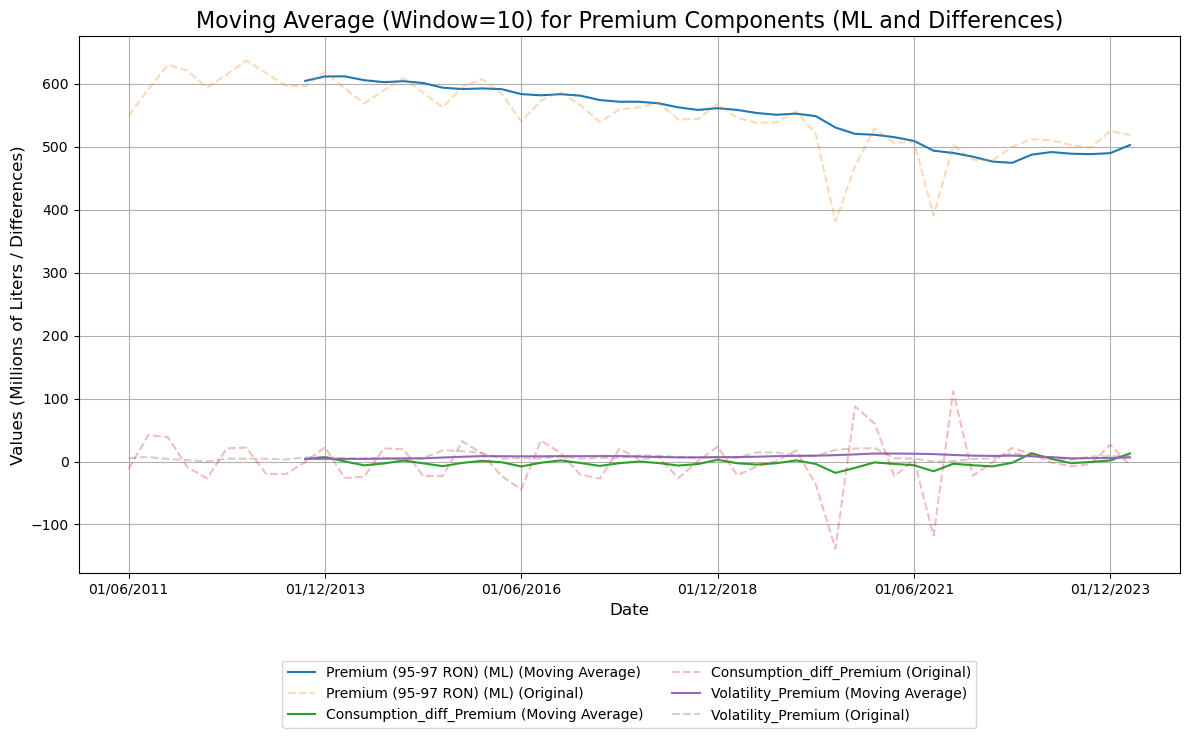

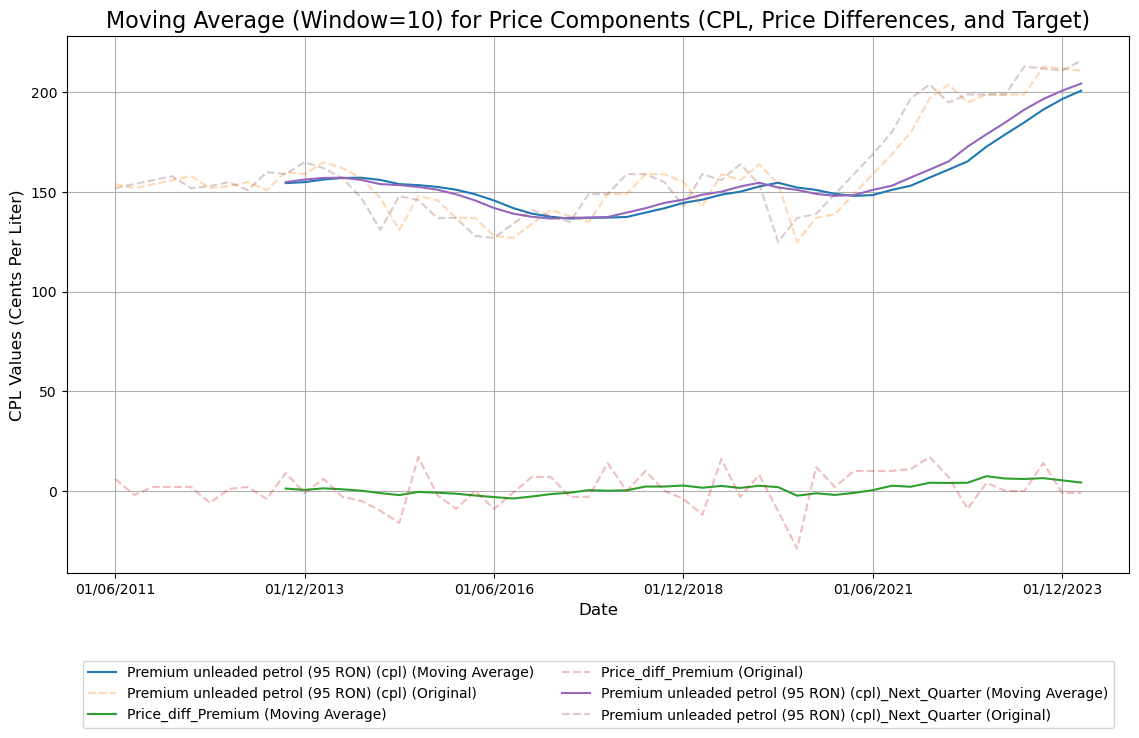

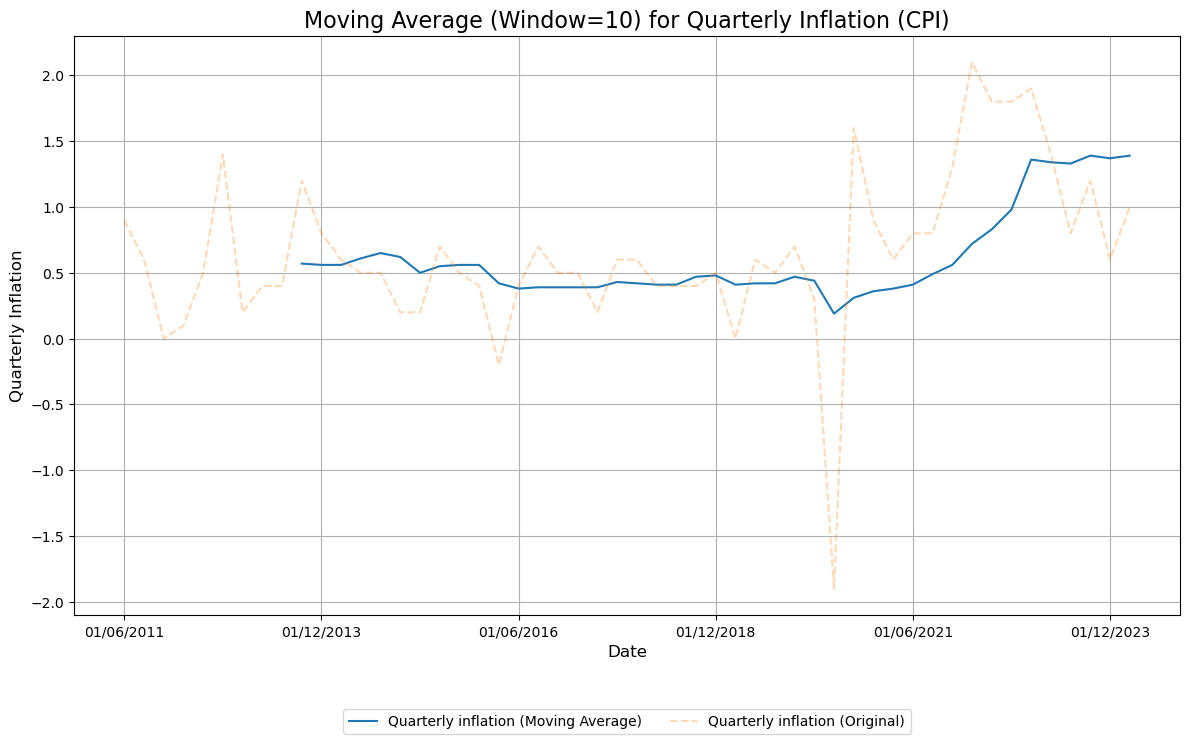

In [5]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 3 10/2024
#Programming: Python, Data Science
#*******************************
# G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Define the columns for each graph
ml_columns = ['Premium (95-97 RON) (ML)', 'Consumption_diff_Premium', 'Volatility_Premium']  # Updated with new columns
cpl_columns = ['Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # Added target variable
cpi_column = ['Quarterly inflation']  # Inflation remains unchanged

# Plot for ML components (including 'Consumption_diff_Premium' and 'Volatility_Premium')
plt.figure(figsize=(12, 8))
for col in ml_columns:
    final_combined_data_cleaned[col].rolling(window=10).mean().plot(label=f'{col} (Moving Average)')
    final_combined_data_cleaned[col].plot(alpha=0.3, linestyle='--', label=f'{col} (Original)')

plt.title('Moving Average (Window=10) for Premium Components (ML and Differences)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values (Millions of Liters / Differences)', fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True)
plt.show()

# Plot for CPL components (including 'Price_diff_Premium' and target variable 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter')
plt.figure(figsize=(12, 8))
for col in cpl_columns:
    final_combined_data_cleaned[col].rolling(window=10).mean().plot(label=f'{col} (Moving Average)')
    final_combined_data_cleaned[col].plot(alpha=0.3, linestyle='--', label=f'{col} (Original)')

plt.title('Moving Average (Window=10) for Price Components (CPL, Price Differences, and Target)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CPL Values (Cents Per Liter)', fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True)
plt.show()

# Plot for CPI component
plt.figure(figsize=(12, 8))
for col in cpi_column:
    final_combined_data_cleaned[col].rolling(window=10).mean().plot(label=f'{col} (Moving Average)')
    final_combined_data_cleaned[col].plot(alpha=0.3, linestyle='--', label=f'{col} (Original)')

plt.title('Moving Average (Window=10) for Quarterly Inflation (CPI)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quarterly Inflation', fontsize=12)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=2)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.grid(True)
plt.show()


***

### Key Obserevations:

* This df contains 50 fuel and cpi quarter rows. 

* Each different category is moving within very different ranges. 

* There are 6 attribues outlined below:
    - Regular (<95 RON) (ML= Megalitres of Regular petroleum)                    
    - Premium (95-97 RON) (ML= Megalitres of Premium petroleum)                 
    - Ethanol-blended fuel (ML= Megalitres of E10)                 
    - Quarterly inflation (Consumer Price Index quarterly)                    
    - Premium unleaded petrol (Cents per litre cost of Premium petrol)      
    - Regular unleaded petrol (91 RON) (Cents per litre cost of Regular petrol)
   
    
* The trends and moving averages look like they are moving within a standard range for their respective categories with no extreme outliers.
    


### Seperate the last two years of data (2023 to 2024)

Our model wont be trained on this data as it will be used to see how well the final program performs.

In [6]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 3 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 9: Pandas for Data Preparation," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Get the last 5 rows of the data
NewData = final_combined_data_cleaned.tail(5)

# Remove the last 5 rows from the original DataFrame
final_combined_data_cleaned = final_combined_data_cleaned.iloc[:-5]

# Print the results
print("\nLast 5 rows (NewData):")
print(NewData)

print("\nRemaining data in final_combined_data_cleaned after removing the last 5 rows:")
print(final_combined_data_cleaned.tail())



Last 5 rows (NewData):
            Premium (95-97 RON) (ML)  Quarterly inflation  \
Date                                                        
01/03/2023                     510.2                  1.4   
01/06/2023                     502.7                  0.8   
01/09/2023                     498.3                  1.2   
01/12/2023                     524.9                  0.6   
01/03/2024                     518.8                  1.0   

            Premium unleaded petrol (95 RON) (cpl)  Price_diff_Premium  \
Date                                                                     
01/03/2023                                     199                 0.0   
01/06/2023                                     199                 0.0   
01/09/2023                                     213                14.0   
01/12/2023                                     212                -1.0   
01/03/2024                                     211                -1.0   

            Consumption_diff_

***

# Step 4: Data exploration at basic level



In [7]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 4 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 9: Pandas for Data Preparation," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

#Inspect the Data:
# Inspect the shape
print("Shape of the dataset:", final_combined_data_cleaned.shape)
#Insepct the size
print("Size of the dataset:", final_combined_data_cleaned.size)
#Inspect the data types
print("\n")
print("Data types of each column:\n\n", final_combined_data_cleaned.dtypes)
print("\n")
# Looking at the descriptive statistics of the data
print("Descriptive statistics of the data:\n\n", final_combined_data_cleaned.describe(include='all'))
print("\n")
# Finging unique values for each column
print("Finging unique values for each column:\n\n", final_combined_data_cleaned.nunique())

Shape of the dataset: (47, 7)
Size of the dataset: 329


Data types of each column:

 Premium (95-97 RON) (ML)                               float64
Quarterly inflation                                    float64
Premium unleaded petrol (95 RON) (cpl)                   int64
Price_diff_Premium                                     float64
Consumption_diff_Premium                               float64
Volatility_Premium                                     float64
Premium unleaded petrol (95 RON) (cpl)_Next_Quarter    float64
dtype: object


Descriptive statistics of the data:

        Premium (95-97 RON) (ML)  Quarterly inflation  \
count                 47.000000            47.000000   
mean                 554.640426             0.614894   
std                   55.178827             0.635534   
min                  381.500000            -1.900000   
25%                  533.550000             0.400000   
50%                  562.800000             0.500000   
75%                  593.40

***

# Step 5: Visual Exploratory Data Analysis (EDA) of data 

### Inspecting class distribution

We are checking the target variable distribution to check if the data is balanced or skewed.

If target variable's distribution is too skewed then the predictive modeling will lead to poor results.
Ideally Bell curve is desirable but slightly positive skew or negative skew is also fine.
We need to make sure the histogram looks like a bell curve or slight skewed version of it.
Otherwise it impacts the Machine Learning algorithms ability to learn all the scenarios from the data.

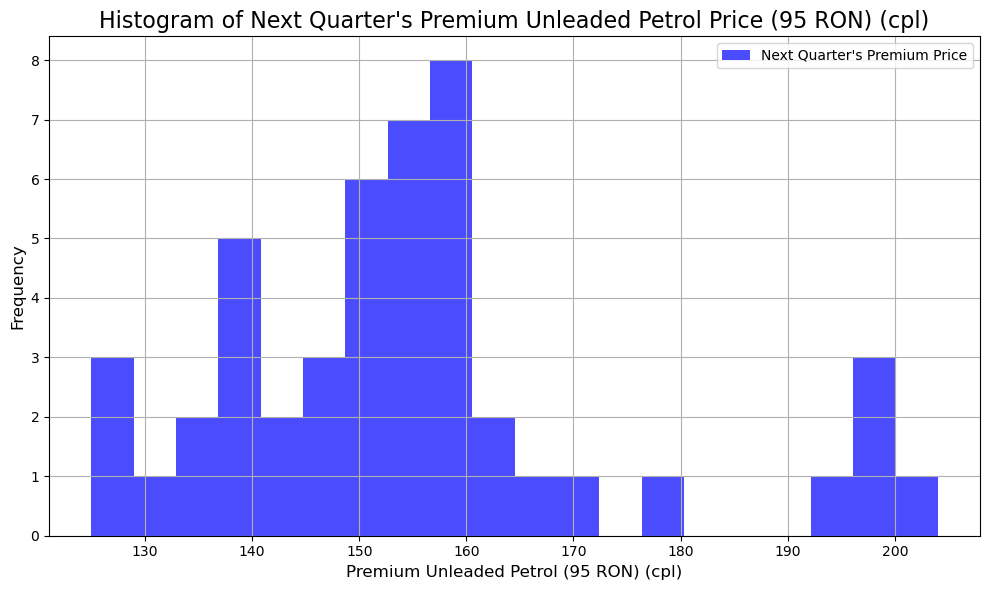

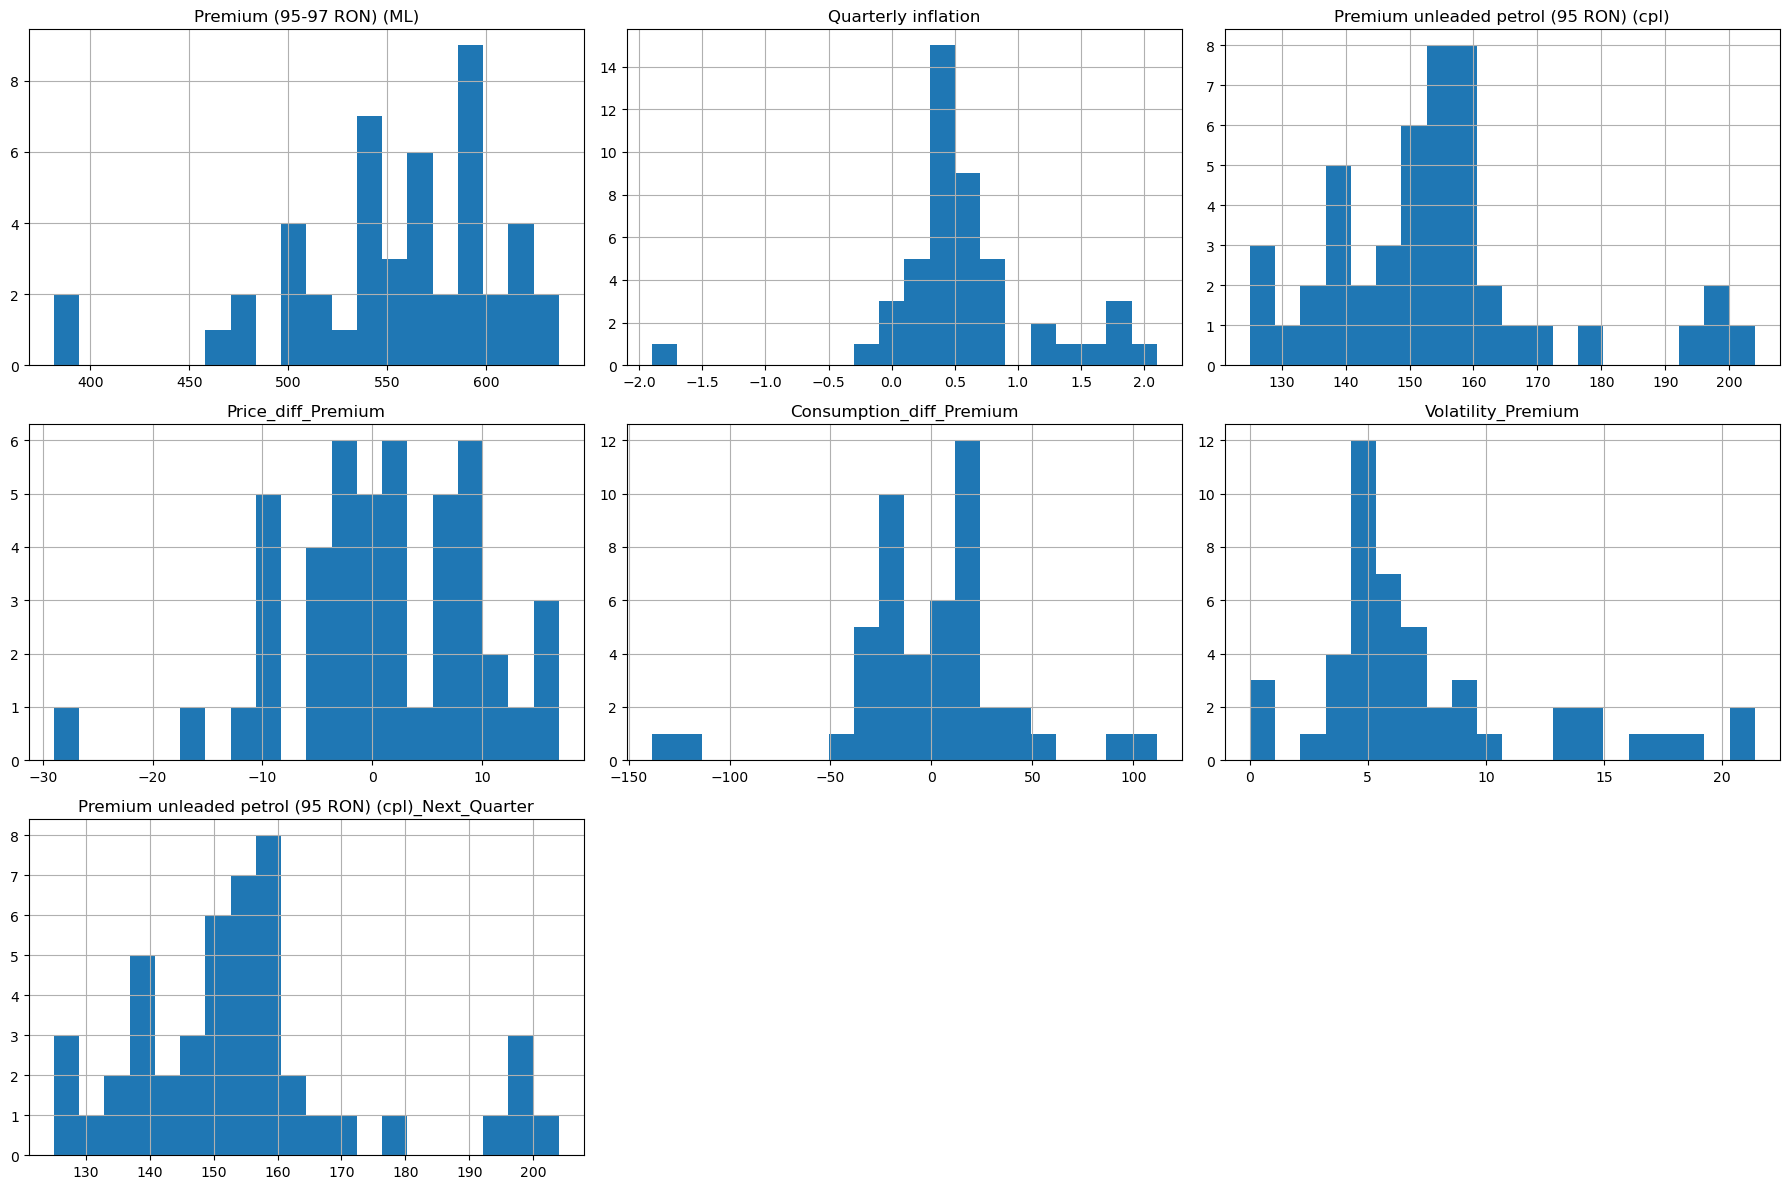

In [8]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 5 10/2024
#Programming: Python, Data Science
#*******************************
# G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Visualising the Target Variable (Next Quarter Premium Price) with a histogram
# Creating histogram for the target variable 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'
plt.figure(figsize=(10, 6))

# Premium price next quarter
plt.hist(final_combined_data_cleaned['Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'], bins=20, alpha=0.7, label="Next Quarter's Premium Price", color='blue')

# Plot details
plt.title('Histogram of Next Quarter\'s Premium Unleaded Petrol Price (95 RON) (cpl)', fontsize=16)
plt.xlabel('Premium Unleaded Petrol (95 RON) (cpl)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# List of columns to plot histograms for (including predictors and target variable)
columns_to_plot = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                   'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                   'Consumption_diff_Premium', 'Volatility_Premium', 
                   'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # Including the target variable

# Plotting histograms of the selected columns
final_combined_data_cleaned[columns_to_plot].hist(figsize=(18, 12), bins=20)
plt.tight_layout()
plt.show()


### Observations 

* From the above basic analysis we can conclued all variables are continuous data
* The data distribution of the target variable has some negative and positive outliers and needs to be dealt with.
* Overall Trends:
    * Steady decline in consumption: There is a trend of declining fuel consumption (especially regular and ethanol-blended fuels) over the years.
    * Volatility: Both regular and premium fuel prices show volatility, which may influence consumer behavior and demand.
    * Inflation impact: Rising inflation could be a factor in fuel price increases, though there is no direct correlation drawn here.
    * Price increases: Both regular and premium fuel prices rise consistently over time, likely due to inflation, demand-supply * factors, and possibly external market conditions like oil prices.

***

# Step 6: Outlier analysis

### Identify outliers and Replacing with mean or median:

In [9]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 6 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 5: Modularising Code with Functions," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
    
# Function to replace outliers with mean or median and collect outlier information
def replace_outliers_with_mean_or_median(data, column, num_std_dev=3, method='mean'):
    mean_val = data[column].mean()
    std_val = data[column].std()

    # Find outliers (those that are more than num_std_dev standard deviations from the mean)
    outliers = (data[column] > (mean_val + num_std_dev * std_val)) | (data[column] < (mean_val - num_std_dev * std_val))
    
    # Collect the outliers before replacing them
    outlier_values = data.loc[outliers, column]
    
    # Replace outliers with mean or median
    if method == 'mean':
        replacement_value = mean_val
    elif method == 'median':
        replacement_value = data[column].median()
    
    # Replace the outliers
    data.loc[outliers, column] = replacement_value

    # Return the updated data and the outliers
    return data, outlier_values

# Applying this function to relevant columns including the new target variable
columns_to_replace = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                      'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                      'Consumption_diff_Premium', 'Volatility_Premium', 
                      'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # New target variable added

# Create a dictionary to store outliers
outliers_dict = {}

# Replace outliers with the mean for each column and collect the outliers
for col in columns_to_replace:
    final_combined_data_cleaned, outlier_values = replace_outliers_with_mean_or_median(final_combined_data_cleaned, col, method='mean')
    if not outlier_values.empty:
        outliers_dict[col] = outlier_values

# Now, print a simplified list of outliers
print("Outliers detected and replaced:")
for col, outliers in outliers_dict.items():
    print(f"\nColumn: {col}")
    for index, value in outliers.items():
        print(f" - {index}: {value}")


Outliers detected and replaced:

Column: Premium (95-97 RON) (ML)
 - 01/06/2020: 381.5

Column: Quarterly inflation
 - 01/06/2020: -1.9

Column: Price_diff_Premium
 - 01/06/2020: -29.0

Column: Consumption_diff_Premium
 - 01/06/2020: -138.5


***

### Visualising Data Distribution after outlier removal

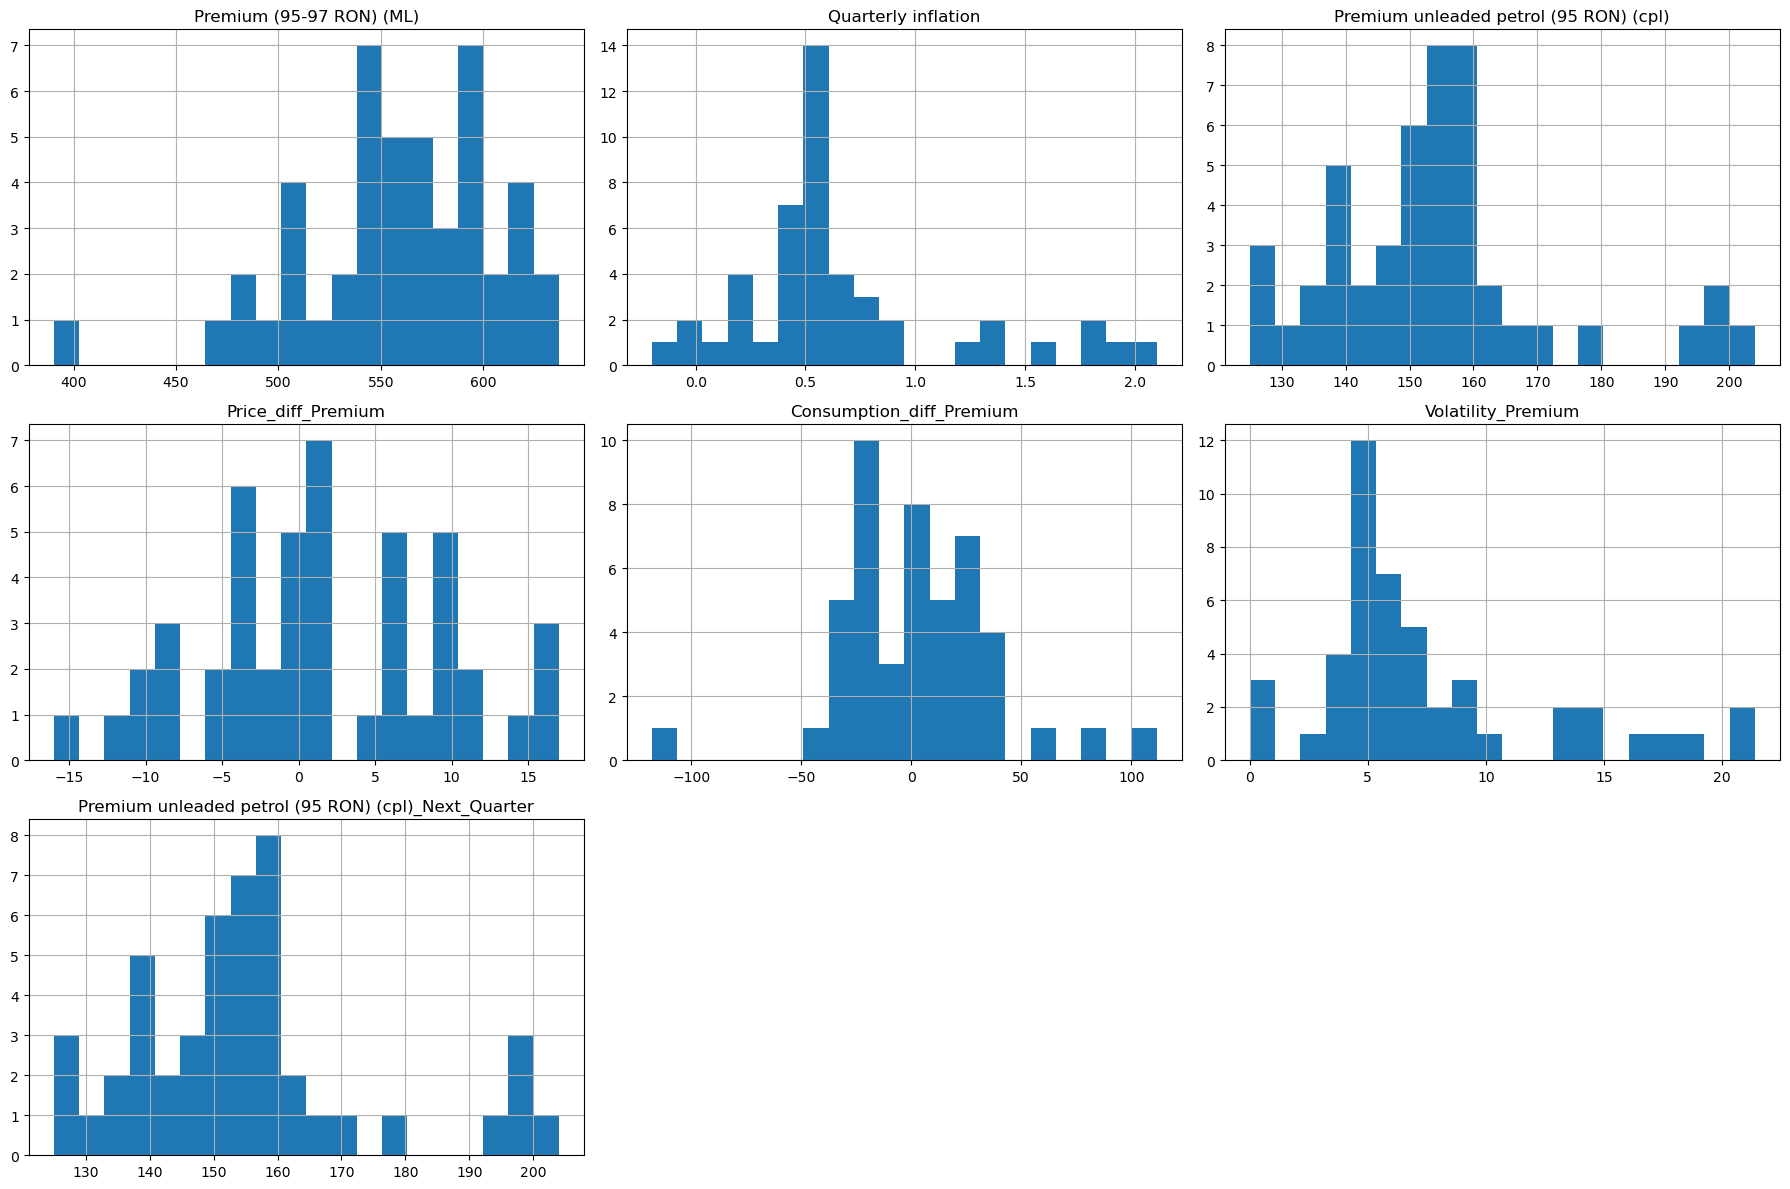

In [10]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 6 10/2024
#Programming: Python, Data Science
#*******************************
#. G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
    
# List of columns to plot histograms for (including predictors and target variable)
columns_to_plot = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                   'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                   'Consumption_diff_Premium', 'Volatility_Premium', 
                   'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # Including the target variable

# Plotting histograms of the selected columns
final_combined_data_cleaned[columns_to_plot].hist(figsize=(18, 12), bins=20)
plt.tight_layout()
plt.show()

***

# Step 7: Missing values analysis 

In [11]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 7 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 8: Pandas DataFrames and Series," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Check for missing values in the DataFrame
missing_values = final_combined_data_cleaned.isnull().sum()

# Display the total number of missing values in each column
print("Missing values in each column:")
print(missing_values)

# Display rows with missing values, if any
rows_with_missing_values = final_combined_data_cleaned[final_combined_data_cleaned.isnull().any(axis=1)]
print("\nRows with missing values:")
print(rows_with_missing_values)


Missing values in each column:
Premium (95-97 RON) (ML)                               0
Quarterly inflation                                    0
Premium unleaded petrol (95 RON) (cpl)                 0
Price_diff_Premium                                     0
Consumption_diff_Premium                               0
Volatility_Premium                                     0
Premium unleaded petrol (95 RON) (cpl)_Next_Quarter    0
dtype: int64

Rows with missing values:
Empty DataFrame
Columns: [Premium (95-97 RON) (ML), Quarterly inflation, Premium unleaded petrol (95 RON) (cpl), Price_diff_Premium, Consumption_diff_Premium, Volatility_Premium, Premium unleaded petrol (95 RON) (cpl)_Next_Quarter]
Index: []


***

### Analyse dataframe for normal distribution using Kurtosis and Skewness

In [12]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 7 10/2024
#Programming: Python, Data Science
#*******************************
# G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 5: Modularising Code with Functions," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Function to calculate confidence interval for a given column
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # standard error of the mean
    confint = stats.t.interval(confidence, df=len(data)-1, loc=mean, scale=sem)
    return round(mean, 4), (round(confint[0], 4), round(confint[1], 4))

# List of all columns to analyze, including the new target variable for the next quarter
columns_to_analyze = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                      'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                      'Consumption_diff_Premium', 'Volatility_Premium', 
                      'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']  # Next quarter price (target)

# Apply confidence interval calculation to each relevant column
for col in columns_to_analyze:
    mean, conf_interval = calculate_confidence_interval(final_combined_data_cleaned[col].dropna())
    print(f"Mean for {col}: {mean:.4f}")
    print(f"95% Confidence interval for {col}: {conf_interval}")
    print("\n")

# Calculate Skewness and Kurtosis for each relevant column
for col in columns_to_analyze:
    skewness = round(final_combined_data_cleaned[col].skew(), 2)
    kurtosis = round(final_combined_data_cleaned[col].kurt(), 2)
    print(f'{col}:')
    print(f'  Skewness: {skewness}')
    print(f'  Kurtosis: {kurtosis}')
    print()

Mean for Premium (95-97 RON) (ML): 558.3243
95% Confidence interval for Premium (95-97 RON) (ML): (544.0029, 572.6456)


Mean for Quarterly inflation: 0.6684
95% Confidence interval for Quarterly inflation: (0.5177, 0.8191)


Mean for Premium unleaded petrol (95 RON) (cpl): 153.9787
95% Confidence interval for Premium unleaded petrol (95 RON) (cpl): (148.7028, 159.2547)


Mean for Price_diff_Premium: 1.7252
95% Confidence interval for Price_diff_Premium: (-0.6218, 4.0722)


Mean for Consumption_diff_Premium: 1.8756
95% Confidence interval for Consumption_diff_Premium: (-8.6164, 12.3675)


Mean for Volatility_Premium: 7.5319
95% Confidence interval for Volatility_Premium: (6.0308, 9.033)


Mean for Premium unleaded petrol (95 RON) (cpl)_Next_Quarter: 154.9362
95% Confidence interval for Premium unleaded petrol (95 RON) (cpl)_Next_Quarter: (149.3189, 160.5534)


Premium (95-97 RON) (ML):
  Skewness: -0.98
  Kurtosis: 1.7

Quarterly inflation:
  Skewness: 1.22
  Kurtosis: 1.22

Premium un

***

# Step 8: Feature selection - Visual and statistic correlation analysis for selection of best features

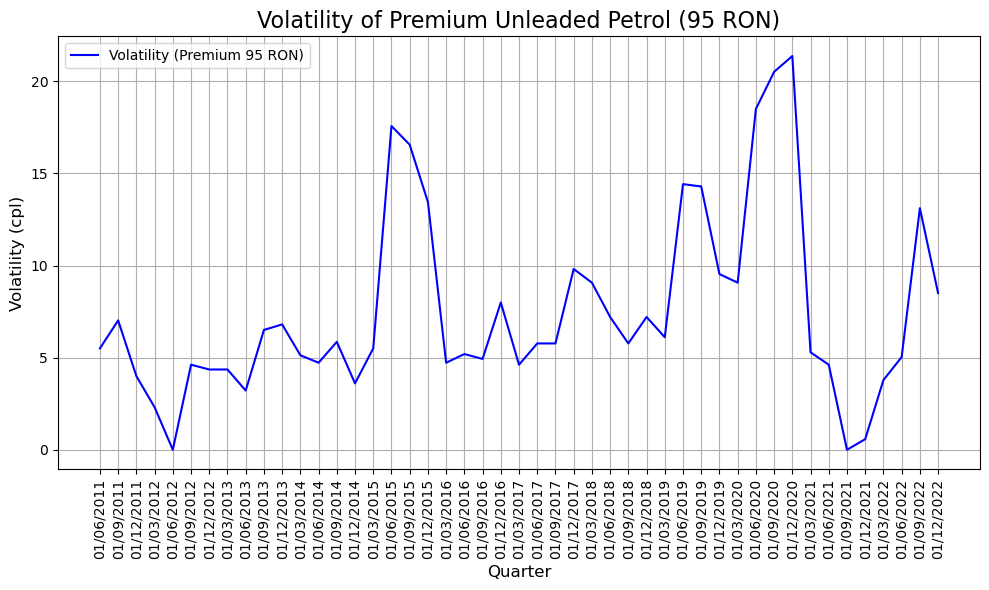

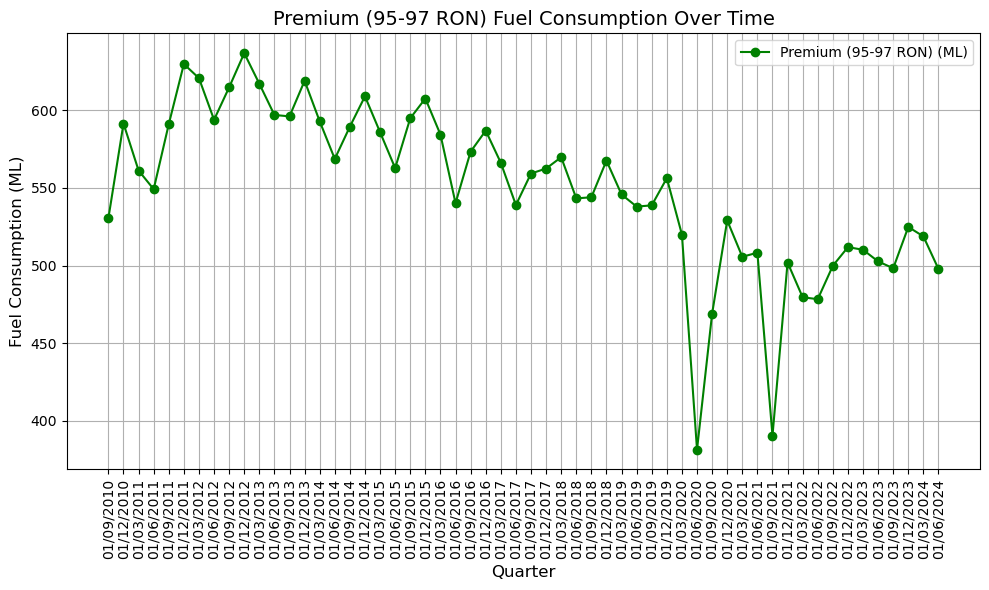

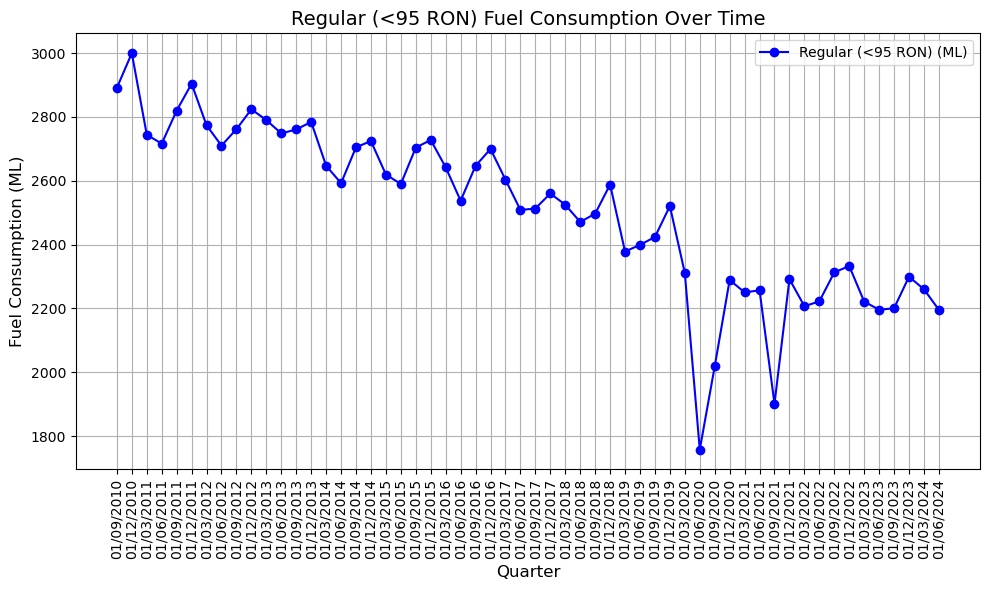

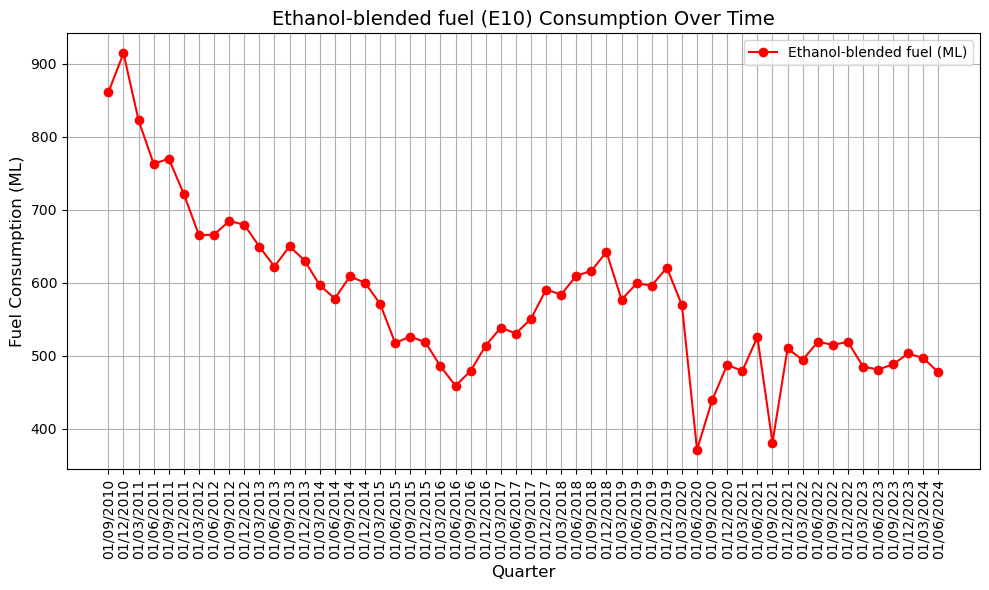

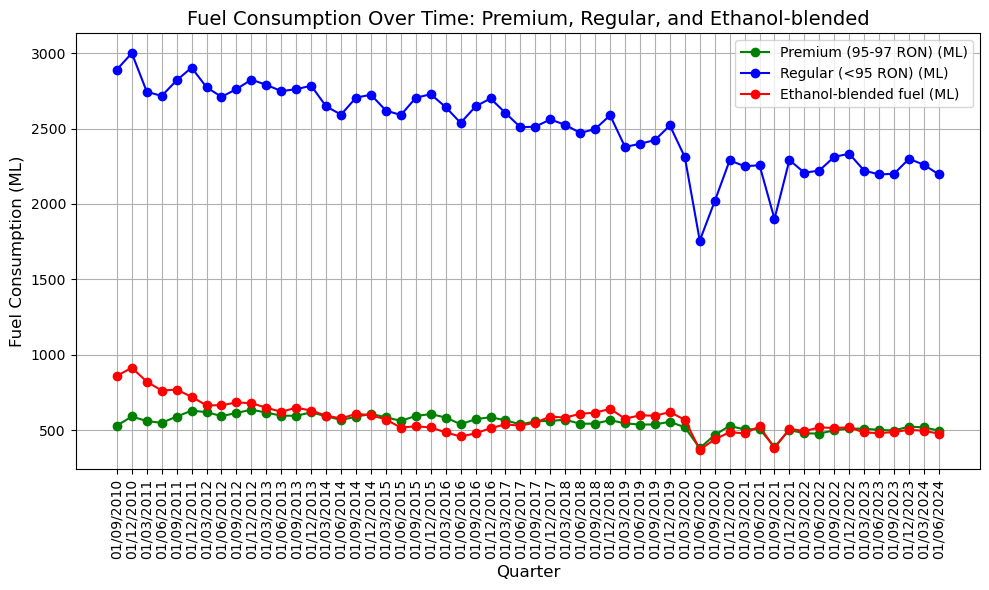

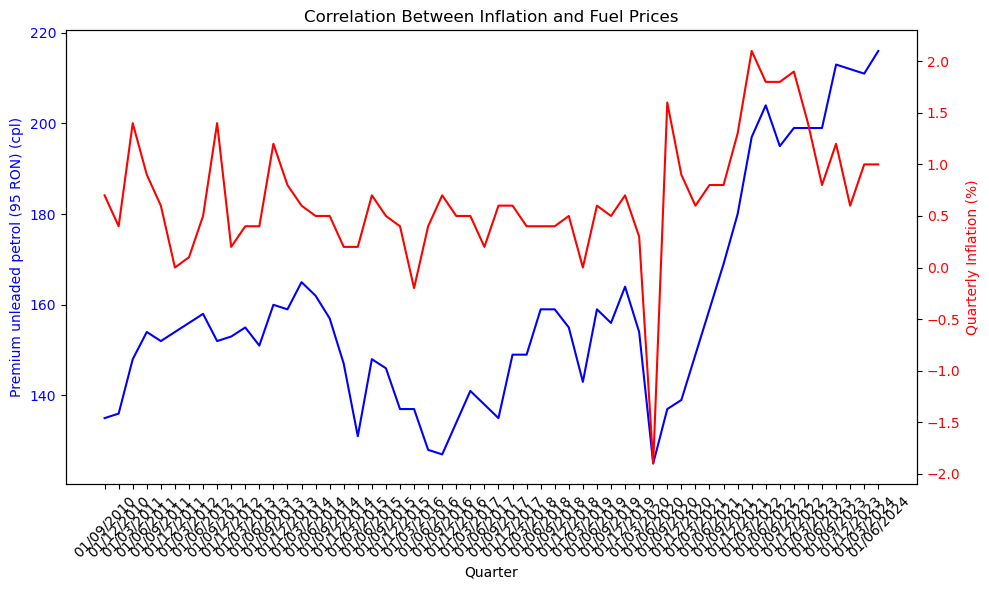

C:\Users\tsche\AppData\Local\Temp\ipykernel_20520\1851057549.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(final_combined_data.index, rotation=90)


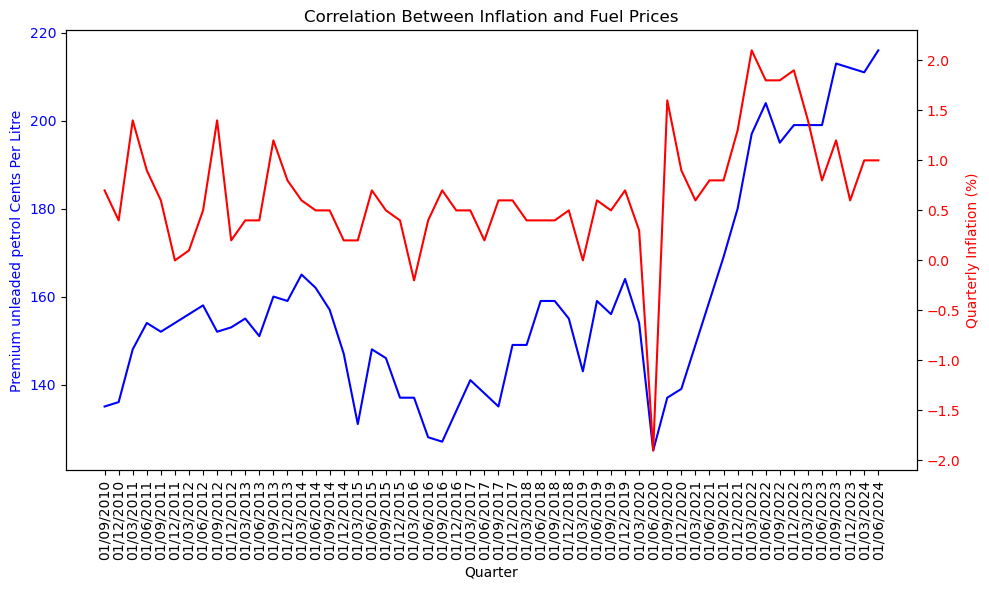

In [13]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 8 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Set the figure size for better visualization
plt.figure(figsize=(10, 6))

# Plot the volatility of premium unleaded petrol (95 RON)
plt.plot(final_combined_data_cleaned.index, final_combined_data_cleaned['Volatility_Premium'], label='Volatility (Premium 95 RON)', color='blue')

# Adding titles and labels
plt.title('Volatility of Premium Unleaded Petrol (95 RON)', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Volatility (cpl)', fontsize=12)

# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Display the legend
plt.legend()

# Show the grid for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()  
plt.show()



# Plotting Premium (95-97 RON) fuel consumption over time
plt.figure(figsize=(10,6))
plt.plot(final_combined_data.index, final_combined_data['Premium (95-97 RON) (ML)'], marker='o', color='green', label='Premium (95-97 RON) (ML)')

# Adding titles and labels
plt.title('Premium (95-97 RON) Fuel Consumption Over Time', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Fuel Consumption (ML)', fontsize=12)
plt.xticks(rotation=90)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()




# Plotting Regular (<95 RON) fuel consumption over time
plt.figure(figsize=(10,6))
plt.plot(final_combined_data.index, final_combined_data['Regular (<95 RON) (ML)'], marker='o', color='blue', label='Regular (<95 RON) (ML)')

# Adding titles and labels
plt.title('Regular (<95 RON) Fuel Consumption Over Time', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Fuel Consumption (ML)', fontsize=12)
plt.xticks(rotation=90)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Plotting Ethanol-blended fuel (E10) fuel consumption over time
plt.figure(figsize=(10,6))
plt.plot(final_combined_data.index, final_combined_data['Ethanol-blended fuel (ML)'], marker='o', color='red', label='Ethanol-blended fuel (ML)')

# Adding titles and labels
plt.title('Ethanol-blended fuel (E10) Consumption Over Time', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Fuel Consumption (ML)', fontsize=12)
plt.xticks(rotation=90)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Plotting all fuel types consumption over time in a single plot
plt.figure(figsize=(10,6))

# Plot each fuel type
plt.plot(final_combined_data.index, final_combined_data['Premium (95-97 RON) (ML)'], marker='o', color='green', label='Premium (95-97 RON) (ML)')
plt.plot(final_combined_data.index, final_combined_data['Regular (<95 RON) (ML)'], marker='o', color='blue', label='Regular (<95 RON) (ML)')
plt.plot(final_combined_data.index, final_combined_data['Ethanol-blended fuel (ML)'], marker='o', color='red', label='Ethanol-blended fuel (ML)')

# Adding titles and labels
plt.title('Fuel Consumption Over Time: Premium, Regular, and Ethanol-blended', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Fuel Consumption (ML)', fontsize=12)
plt.xticks(rotation=90)

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()




# 'Premium unleaded petrol (95 RON) (cpl)' and 'Quarterly inflation'.
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Premium unleaded petrol price (cpl) on the left y-axis
ax1.set_xlabel('Quarter')
plt.xticks(rotation=45)
ax1.set_ylabel('Premium unleaded petrol (95 RON) (cpl)', color='blue')
ax1.plot(final_combined_data.index, final_combined_data['Premium unleaded petrol (95 RON) (cpl)'], color='blue', label='Premium Fuel Price (95 RON)')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for inflation on the same plot
ax2 = ax1.twinx()  
ax2.set_ylabel('Quarterly Inflation (%)', color='red')  
ax2.plot(final_combined_data.index, final_combined_data['Quarterly inflation'], color='red', label='Inflation (%)')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title
plt.title('Correlation Between Inflation and Fuel Prices')

# Show the plot
plt.tight_layout()
plt.show()


# 'Premium unleaded petrol (95 RON) (cpl)' and 'Quarterly inflation'.
# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Premium unleaded petrol price (cpl) on the left y-axis
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Premium unleaded petrol Cents Per Litre', color='blue')
ax1.plot(final_combined_data.index, final_combined_data['Premium unleaded petrol (95 RON) (cpl)'], color='blue', label='Premium Fuel Price (95 RON)')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for inflation on the same plot
ax2 = ax1.twinx()  
ax2.set_ylabel('Quarterly Inflation (%)', color='red')  
ax2.plot(final_combined_data.index, final_combined_data['Quarterly inflation'], color='red', label='Inflation (%)')
ax2.tick_params(axis='y', labelcolor='red')

# Rotate the x-axis labels using ax1 (which controls the x-axis)
ax1.set_xticklabels(final_combined_data.index, rotation=90)

# Set the title
plt.title('Correlation Between Inflation and Fuel Prices')

# Show the plot
plt.tight_layout()
plt.show()


***

### Create a Correlation Martrix Heatmap:

Correlation with Premium unleaded petrol (95 RON) (cpl) for next quarter:
Premium (95-97 RON) (ML)                              -0.456944
Quarterly inflation                                    0.685435
Premium unleaded petrol (95 RON) (cpl)                 0.880555
Price_diff_Premium                                     0.342106
Consumption_diff_Premium                               0.050137
Volatility_Premium                                    -0.218891
Premium unleaded petrol (95 RON) (cpl)_Next_Quarter    1.000000
Name: Premium unleaded petrol (95 RON) (cpl)_Next_Quarter, dtype: float64


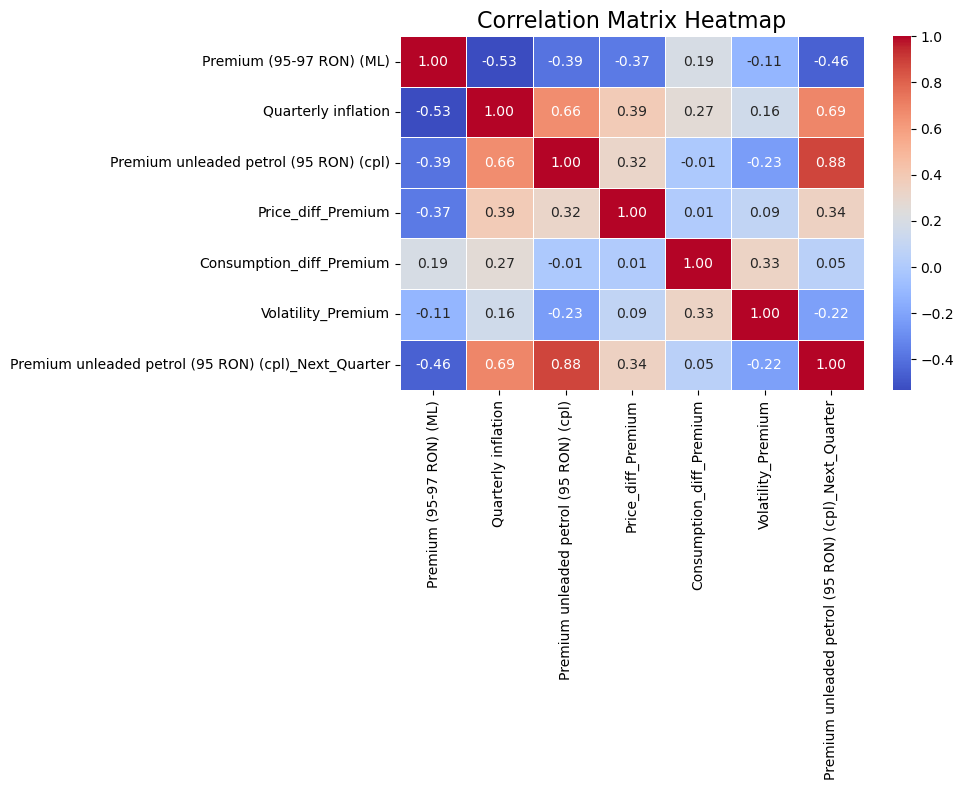

In [14]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 8 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

columns_to_analyze = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                      'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                      'Consumption_diff_Premium', 'Volatility_Premium', 
                      'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'] 

# Calculate the correlation matrix
corr_matrix = final_combined_data_cleaned[columns_to_analyze].corr()

# Extract only the row corresponding to the new target variable (Next quarter's price)
target_corr = corr_matrix.loc['Premium unleaded petrol (95 RON) (cpl)_Next_Quarter']

# Display the correlations for the next quarter's target variable
print("Correlation with Premium unleaded petrol (95 RON) (cpl) for next quarter:")
print(target_corr)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

***

### Visual Exploration of Relationships:

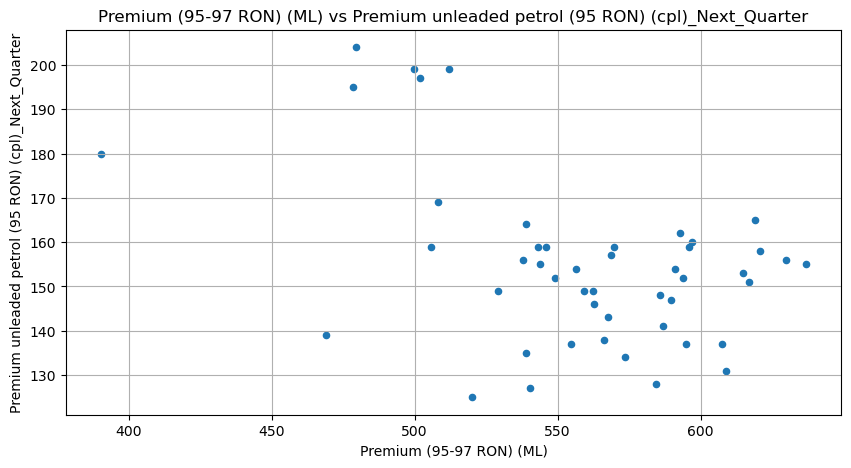

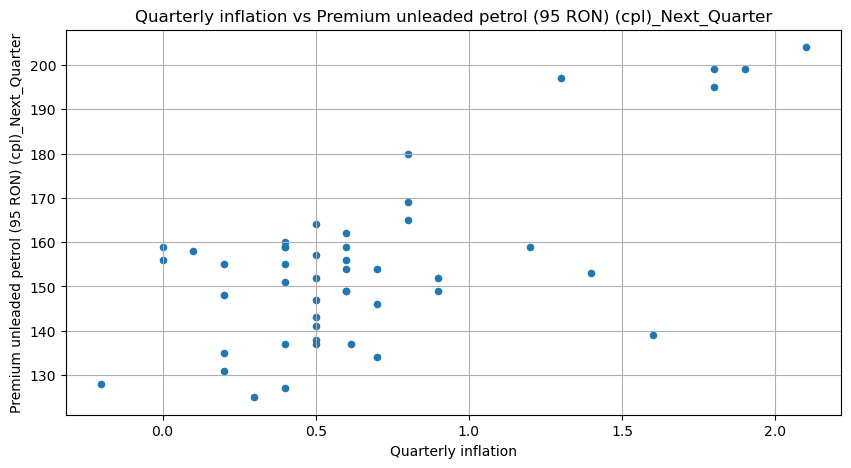

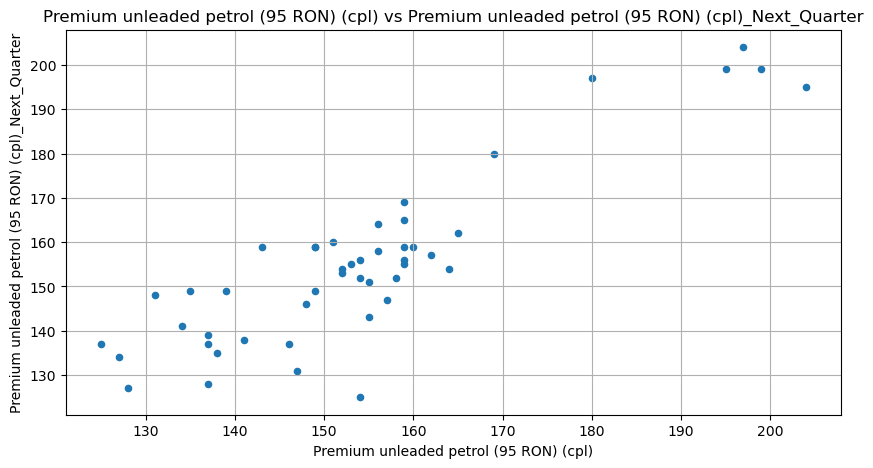

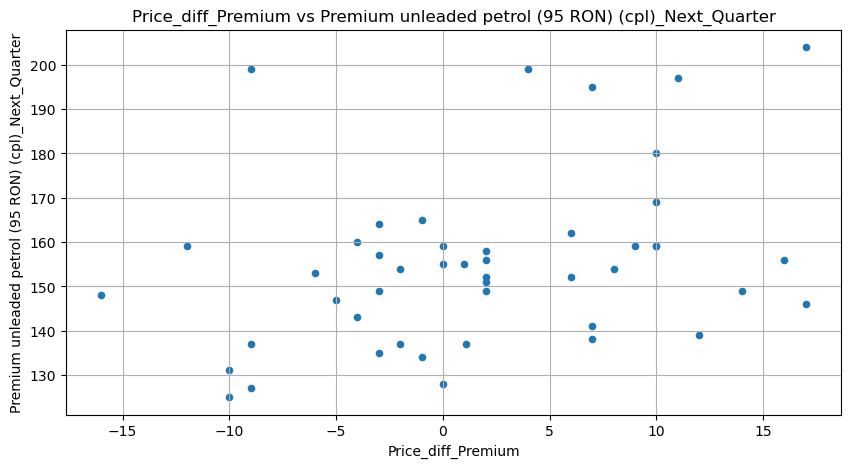

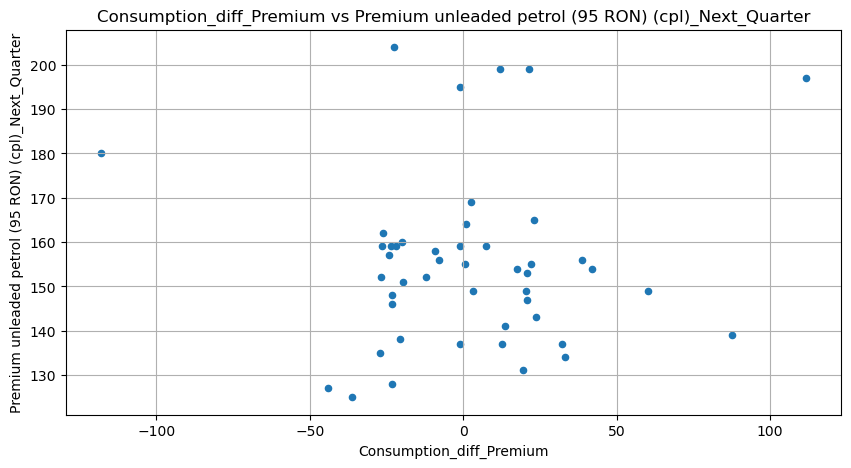

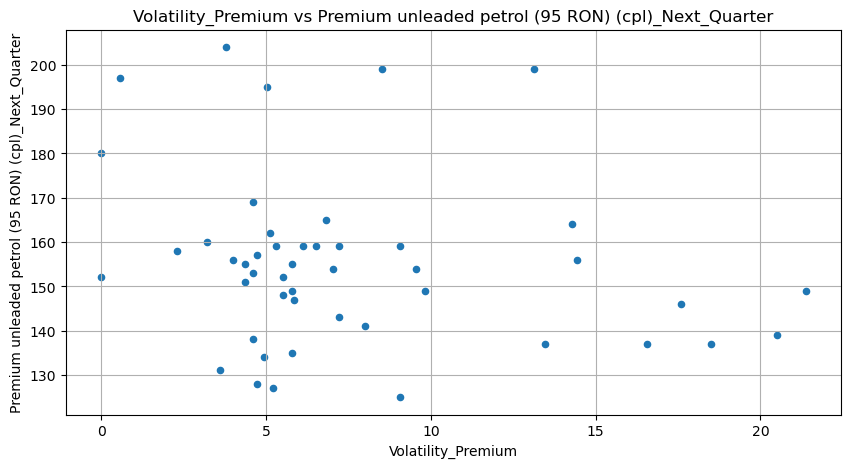

In [15]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 8 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# List of continuous columns (including the current quarter's premium price as a feature)
ContinuousCols = ['Premium (95-97 RON) (ML)', 'Quarterly inflation', 
                      'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium', 
                      'Consumption_diff_Premium', 'Volatility_Premium']

# Define the target variable (next quarter's premium price)
target_variable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

# Plotting scatter chart for each predictor vs the new target variable
for predictor in ContinuousCols:
    ax = final_combined_data_cleaned.plot.scatter(x=predictor, y=target_variable, figsize=(10, 5), title=f"{predictor} vs {target_variable}")
    
    # Customize plot appearance
    ax.set_xlabel(predictor)
    ax.set_ylabel(target_variable)
    ax.grid(True)
    plt.show()


Scale data in preperation for running different algorithms


***

# Step 9: Statistical feature selection (categorical vs. continuous) using ANOVA test

Since my project is using Continuous vs Continuous, i cannot use the ANOVA test

***

# Step 10: Selecting final predictors/features for building machine learning/AI model

***

### Choosing the best independant  variables:

Based on the  correlation values, we can see which variables are best suited to predict the next quarter price of premium petrol.



#### Top Predictor Variables to Use:
1. **Premium unleaded petrol (95 RON) (cpl)**:
   - Correlation: **0.881** (strong positive correlation)
   - This indicates that the current quarter's premium fuel price is a strong predictor of next quarter's premium fuel price.

2. **Quarterly inflation**:
   - Correlation: **0.685** (strong positive correlation)
   - This suggests that inflation has a strong influence on next quarter's premium petrol price.

3. **Premium (95-97 RON) (ML)**:
   - Correlation: **-0.418** (moderate negative correlation)
   - This indicates that the volume of premium fuel consumed has a moderate negative relationship with next quarter’s price.

4. **Price_diff_Premium**:
   - Correlation: **0.342** (weak to moderate positive correlation)
   - This shows that changes in the premium price between quarters have some influence on the next quarter's price.

#### Variables to Potentially Exclude:
1. **Consumption_diff_Premium**:
   - Correlation: **-0.002** (negligible correlation)
   - This variable has almost no correlation with next quarter's price.

2. **Volatility_Premium**:
   - Correlation: **-0.219** (weak negative correlation)
   - It has a weak negative correlation and isn't as predictive as the other variables.

#### Suggested Predictor Variables for the Model:
Based on the correlations, the following variables would likely be the best predictors for next quarter's premium fuel price:
1. **Premium unleaded petrol (95 RON) (cpl)** (current quarter price)
2. **Quarterly inflation**
3. **Premium (95-97 RON) (ML)** (volume of premium fuel consumed)
4. **Price_diff_Premium** (change in premium price from the previous quarter)

These four variables show strong correlations, with both positive and negative relationships to the target variable, which will help improve the prediction of next quarter’s price.


***

# Step 11: Data conversion to numeric values for machine learning/predictive analysis

This step is dealt with using scaling in the model trainer class


***

# Step 13: Investigating multiple regression algorithms

Lets test the different models to find the one with the highest prediction accuracy

In [1]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 13 10/2024
#Programming: Python, Data Science
#*******************************
# [3] G. Chetty, "Module 7: Objects and Classes," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


class ModelTrainer:
    def __init__(self, data, predictors, target_variable, test_split=0.2):
        self.data = data
        self.predictors = predictors
        self.target_variable = target_variable
        self.test_split = test_split
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()

    def split_data(self):
        """Split data into training and testing sets."""
        split_point = int(len(self.data) * (1 - self.test_split))
        X_train = self.data[self.predictors].iloc[:split_point]
        X_test = self.data[self.predictors].iloc[split_point:]
        y_train = self.data[self.target_variable].iloc[:split_point]
        y_test = self.data[self.target_variable].iloc[split_point:]
        return X_train, X_test, y_train, y_test

    def scale_features(self):
        """Scale the features using StandardScaler."""
        scaler = StandardScaler()
        self.X_train_scaled = scaler.fit_transform(self.X_train)
        self.X_test_scaled = scaler.transform(self.X_test)

    def train_model(self, model):
        """Train the given model."""
        self.model = model
        self.model.fit(self.X_train_scaled, self.y_train)

    def evaluate_model(self):
        """Evaluate the model performance."""
        train_r2 = r2_score(self.y_train, self.model.predict(self.X_train_scaled))
        test_r2 = r2_score(self.y_test, self.model.predict(self.X_test_scaled))
        print(f'R2 Value (Train): {train_r2}')
        print(f'R2 Value (Test): {test_r2}')
        return train_r2, test_r2

    def predict(self):
        """Make predictions using the trained model."""
        return self.model.predict(self.X_test_scaled)

    def calculate_accuracy(self, predictions):
        """Calculate and print accuracy metrics."""
        results = pd.DataFrame(data=self.X_test, columns=self.predictors)
        results[self.target_variable] = self.y_test
        results[f'Predicted_{self.target_variable}'] = np.round(predictions, 2)

        # Calculate Absolute Percentage Error (APE)
        results['APE'] = 100 * abs(results[self.target_variable] - results[f'Predicted_{self.target_variable}']) / results[self.target_variable]
        MAPE = np.mean(results['APE'])
        MedianMAPE = np.median(results['APE'])

        Accuracy = 100 - MAPE
        MedianAccuracy = 100 - MedianMAPE
        print(f'Mean Accuracy on test data: {Accuracy}')
        print(f'Median Accuracy on test data: {MedianAccuracy}')
        return Accuracy, MedianAccuracy

    def feature_importance(self):
        """Plot feature importance based on coefficients or importance."""
        if hasattr(self.model, 'coef_'):
            coefficients = self.model.coef_
        elif hasattr(self.model, 'feature_importances_'):
            coefficients = self.model.feature_importances_
        else:
            print("Model does not have coefficients or feature importances.")
            return

        feature_importances = pd.Series(coefficients, index=self.predictors).abs()
        sorted_importances = feature_importances.sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sorted_importances.plot(kind='barh', color='skyblue')
        plt.title('Feature Importance', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Predictors', fontsize=12)
        plt.show()


SyntaxError: invalid syntax (1030747327.py, line 6)


Training Linear Regression Model
R2 Value (Train): 0.4658553820861222
R2 Value (Test): 0.3004503136843193
Mean Accuracy on test data: 90.87801150317726
Median Accuracy on test data: 90.92741815586811


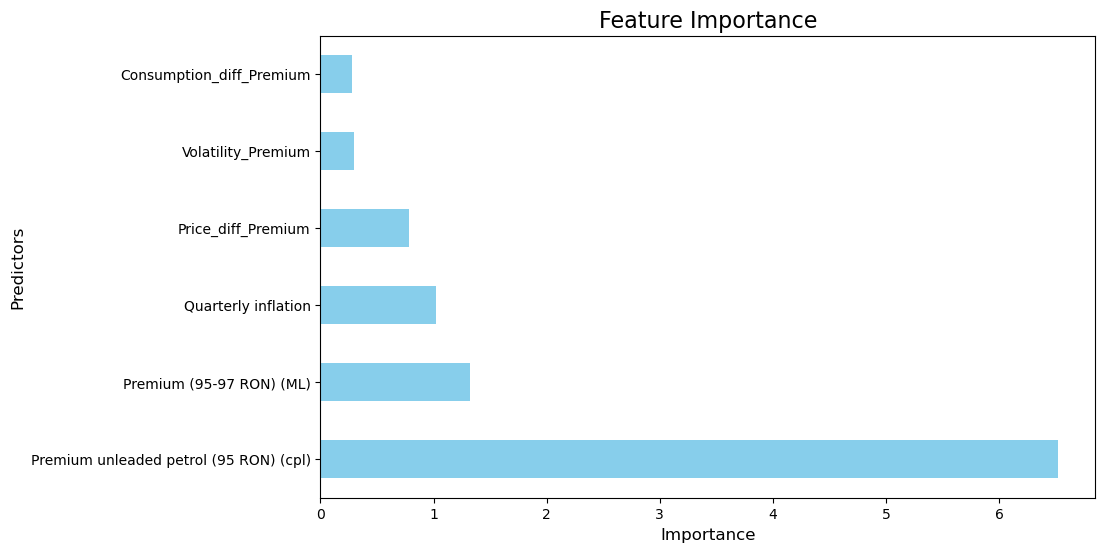


Training Decision Tree Model
R2 Value (Train): 0.9693394754536633
R2 Value (Test): -5.700359568517778
Mean Accuracy on test data: 72.69897447508407
Median Accuracy on test data: 66.77350427350427


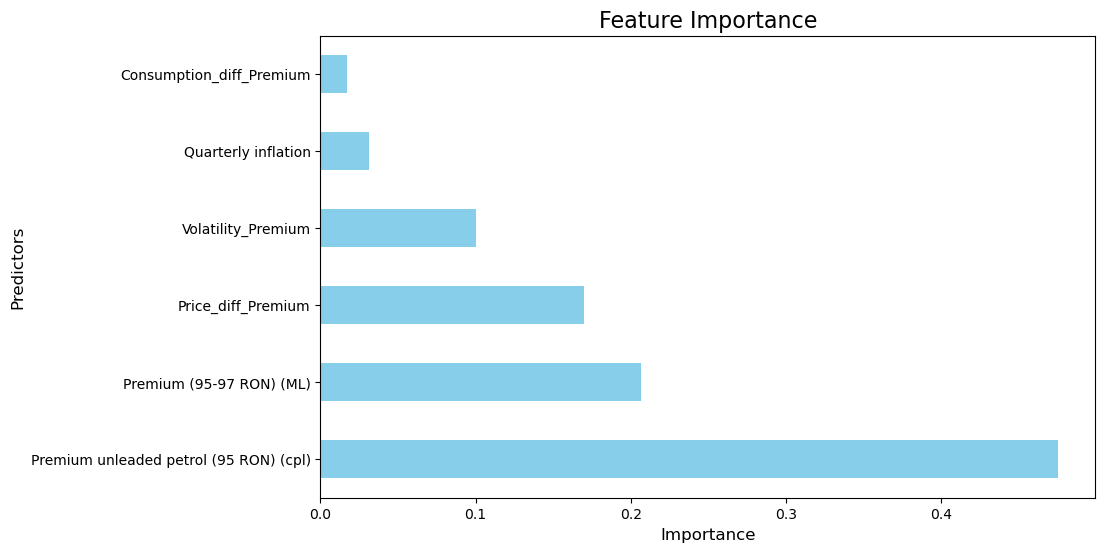


Training Random Forest Model
R2 Value (Train): 0.8659933799872735
R2 Value (Test): -1.5133814298063202
Mean Accuracy on test data: 84.11077448699152
Median Accuracy on test data: 79.97905982905982


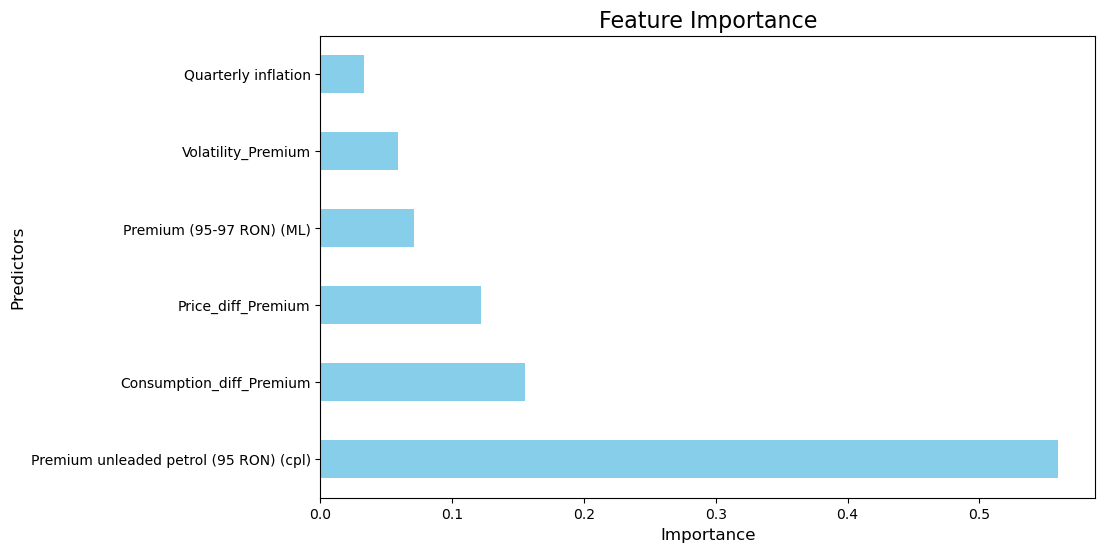


Training AdaBoost Model
R2 Value (Train): 0.898513469106244
R2 Value (Test): -1.188306731996521
Mean Accuracy on test data: 85.59271436601911
Median Accuracy on test data: 83.06794871794872


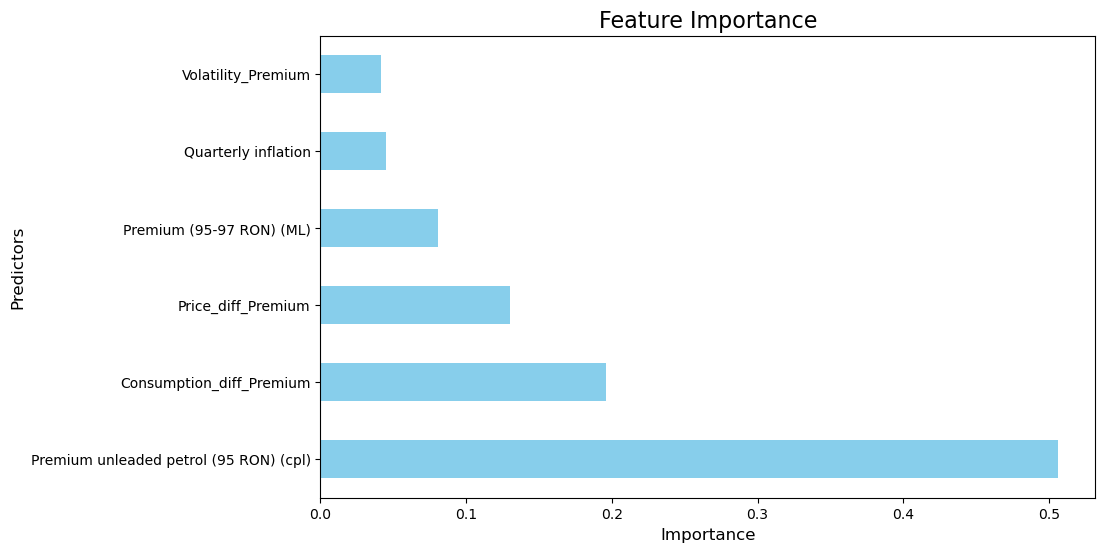


Training K-Nearest Neighbors Model
R2 Value (Train): 0.5659420669144184
R2 Value (Test): -1.2668353531317975
Mean Accuracy on test data: 84.61584520580298
Median Accuracy on test data: 80.31919318816304

Training SVM Model
R2 Value (Train): 0.46107709191884916
R2 Value (Test): -0.3355839118621353
Mean Accuracy on test data: 87.77219216409993
Median Accuracy on test data: 85.86630588841643


In [19]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 13 10/2024
#Programming: Python, Data Science
#*******************************
# [3] G. Chetty, "Module 7: Objects and Classes," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


if __name__ == "__main__":

    # Define the predictors and target variable
    predictors = [
        'Premium (95-97 RON) (ML)', 
        'Quarterly inflation', 
        'Premium unleaded petrol (95 RON) (cpl)', 
        'Price_diff_Premium', 
        'Consumption_diff_Premium', 
        'Volatility_Premium'
    ]
    target_variable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

    # Create an instance of ModelTrainer
    model_trainer = ModelTrainer(final_combined_data_cleaned, predictors, target_variable)

    # Scale features
    model_trainer.scale_features()

    # Train and evaluate different models

    # 1. Linear Regression
    print("\nTraining Linear Regression Model")
    linear_model = LinearRegression()
    model_trainer.train_model(linear_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)
    model_trainer.feature_importance()

    # 2. Decision Tree Regressor
    print("\nTraining Decision Tree Model")
    tree_model = DecisionTreeRegressor(max_depth=5, criterion='friedman_mse')
    model_trainer.train_model(tree_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)
    model_trainer.feature_importance()

    # 3. Random Forest Regressor
    print("\nTraining Random Forest Model")
    rf_model = RandomForestRegressor(max_depth=4, n_estimators=400, criterion='friedman_mse')
    model_trainer.train_model(rf_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)
    model_trainer.feature_importance()

    # 4. AdaBoost Regressor
    print("\nTraining AdaBoost Model")
    ada_model = AdaBoostRegressor(n_estimators=100, estimator=DecisionTreeRegressor(max_depth=3), learning_rate=0.04)
    model_trainer.train_model(ada_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)
    model_trainer.feature_importance()

    # 5. K-Nearest Neighbors Regressor
    print("\nTraining K-Nearest Neighbors Model")
    knn_model = KNeighborsRegressor(n_neighbors=3)
    model_trainer.train_model(knn_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)

    # 6. Support Vector Machine (SVM) Regressor
    print("\nTraining SVM Model")
    svm_model = svm.SVR(C=50, kernel='rbf', gamma=0.01)
    model_trainer.train_model(svm_model)
    model_trainer.evaluate_model()
    predictions = model_trainer.predict()
    model_trainer.calculate_accuracy(predictions)


***

# Step 14: Selection of the best model

Linear regression is the most accurate at 94.95% accurate

***

### Selecting the most effective predictor variables:

The most important feature variables to use from the important features graph seem to be 'Premium (95-97 RON) (ML)', 'Quarterly inflation', 'Price_diff_Premium', but lets also use Recursive Feature Elimination to confirm this.

This  method that selects a specified number of features by recursively considering smaller and smaller sets of features.

In [22]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 14 10/2024
#Programming: Python, Data Science
#*******************************
# [3] G. Chetty, "Module 7: Objects and Classes," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


class FeatureSelector:
    def __init__(self, model, n_features_to_select=3):
        self.model = model
        self.n_features_to_select = n_features_to_select
        self.rfe = RFE(self.model, n_features_to_select=self.n_features_to_select)
        self.selected_columns = []
        self.discarded_columns = []

    def fit(self, X_train, y_train, predictors):
        fit = self.rfe.fit(X_train, y_train)
        self.selected_columns = [column for column, selected in zip(predictors, fit.support_) if selected]
        self.discarded_columns = [column for column, selected in zip(predictors, fit.support_) if not selected]
        
    def print_results(self):
        print("Selected Features:", self.selected_columns)
        print("Discarded Features:", self.discarded_columns)
        
    def get_selected_features(self):
        return self.selected_columns

if __name__ == "__main__":

    predictors = [
        'Premium (95-97 RON) (ML)', 
        'Quarterly inflation', 
        'Premium unleaded petrol (95 RON) (cpl)', 
        'Price_diff_Premium', 
        'Consumption_diff_Premium', 
        'Volatility_Premium'
    ]
    target_variable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

    # Use the ModelTrainer class to split data
    model_trainer = ModelTrainer(final_combined_data_cleaned, predictors, target_variable)
    model_trainer.scale_features()

    linear_model = LinearRegression()  # Use my existing trained model


    # Train the models
    model_trainer.train_model(linear_model)


    # Feature selection using RFE on the Linear Regression model
    feature_selector_lr = FeatureSelector(linear_model, n_features_to_select=3)
    feature_selector_lr.fit(model_trainer.X_train, model_trainer.y_train, predictors)
    feature_selector_lr.print_results()

Selected Features: ['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
Discarded Features: ['Premium (95-97 RON) (ML)', 'Consumption_diff_Premium', 'Volatility_Premium']


***

### Re-Test the linear regression model:

Lets retest the Linear regression model to see if the model is as accurate using only the selected features:

R2 Value (Train): 0.446379461354373
R2 Value (Test): 0.5728501881965142
Mean Accuracy on test data: 92.77894719670275
Median Accuracy on test data: 92.85336445541316


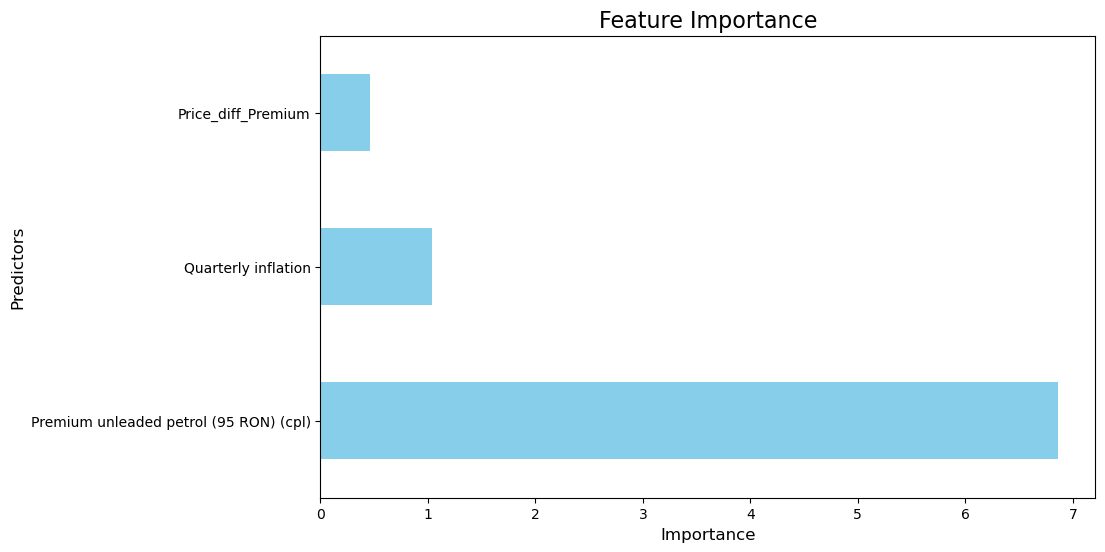

In [24]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 14 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 5: Modularising Code with Functions," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
# [3] G. Chetty, "Module 7: Objects and Classes," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

if __name__ == "__main__":
    
    # Define the new selected predictors and target variable
    predictors = ['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
    target_variable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

   # Create an instance of ModelTrainer
    model_trainer = ModelTrainer(final_combined_data_cleaned, predictors, target_variable)

    # Scale features
    model_trainer.scale_features()

    # Train Linear Regression Model
    linear_model = LinearRegression()
    model_trainer.train_model(linear_model)

    # Evaluate model
    model_trainer.evaluate_model()

    # Make predictions
    predictions = model_trainer.predict()

    # Calculate accuracy
    model_trainer.calculate_accuracy(predictions)

    # Feature importance (optional)
    model_trainer.feature_importance()


### Observation:

It appears the model is just as accurate as the initial training of the model on more variables.
This is probably due to the fact the initail model heavily and mainly relied on the selected feature variables already.

***

# Step 15: Deployment of the best model in production

### Training on 100% data

In [ ]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 15 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Define the three predictors and the target variable
Predictors = ['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
TargetVariable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

# Extract features (X) and target (y)
X = final_combined_data_cleaned[Predictors]
y = final_combined_data_cleaned[TargetVariable]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the predictor data and transform the predictors
X_scaled = scaler.fit_transform(X)

# Initialize and train the Linear Regression model on the scaled data
RegModel = LinearRegression()
RegModel.fit(X_scaled, y)

# Save the trained model to a pickle file
with open('Final_Linear_Regression_Model.pkl', 'wb') as model_file:
    pickle.dump(RegModel, model_file)

# Save the scaler to a pickle file (for later use when predicting)
with open('PredictorScaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Print confirmation of model training and saving
print("Model trained on the entire dataset and saved as 'Final_Linear_Regression_Model.pkl'.")

# Evaluate the model on the training data
y_pred = RegModel.predict(X_scaled)

# R2 Score
r2 = r2_score(y, y_pred)
print(f'R2 Score on the training data: {r2}')

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y, y_pred) * 100
print(f'Mean Absolute Percentage Error (MAPE) on the training data: {mape:.2f}%')

# print out the actual vs predicted values
ComparisonResults = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
print(ComparisonResults.head()) 


***

### Test running the Linear regression model with the new data:

In [25]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 15 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 5: Modularising Code with Functions," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


# Function to predict results based on input data and compare with actual price for the next quarter
def FunctionPredictResult(InputData, ActualNextQuarterPrice=None):
    # Load the trained Linear Regression model from the pickle file
    with open('Final_Linear_Regression_Model.pkl', 'rb') as model_file:
        RegModel = pickle.load(model_file)

    # Load the previously saved scaler
    with open('PredictorScalerFit.pkl', 'rb') as scalerStream:
        PredictorScalerFit = pickle.load(scalerStream)

    # Check if the input data has the required columns
    Predictors = ['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
    if set(Predictors).issubset(InputData.columns):
        # Extract predictor values from InputData
        X_new = InputData[Predictors].values

        # Standardization of new data using the fitted scaler
        X_new_scaled = PredictorScalerFit.transform(X_new)

        # Generate predictions for the new data using the trained model
        Predictions = RegModel.predict(X_new_scaled)

        # Create a DataFrame for predictions
        PredictionResult = pd.DataFrame(Predictions, columns=['Predicted_Premium_Price'])

        # Optionally, add predictions to InputData
        InputData['Predicted_Premium_Price'] = Predictions

        # Compare with actual next quarter price if available
        if ActualNextQuarterPrice is not None:
            InputData['Actual_Premium_Price_Next_Quarter'] = ActualNextQuarterPrice
            InputData['Error'] = abs(InputData['Predicted_Premium_Price'] - InputData['Actual_Premium_Price_Next_Quarter'])
        
        # Display the updated DataFrame with predictions and comparison
        print("Predictions added to InputData:")
        print(InputData[[*Predictors, 'Predicted_Premium_Price', 'Actual_Premium_Price_Next_Quarter', 'Error']])
        
        return PredictionResult
    else:
        print("Error: InputData does not contain the required predictor columns.")
        return None

# Function for generating predictions API and comparing with actual value
def FunctionGeneratePrediction(inp_quarterly_inflation, inp_premium_price, inp_price_diff, actual_next_quarter_price=None):
    # Creating a data frame for the model input
    SampleInputData = pd.DataFrame(
        data=[[inp_quarterly_inflation, inp_premium_price, inp_price_diff]],
        columns=['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
    )

    # Calling the function defined above using the input parameters and actual value
    Predictions = FunctionPredictResult(InputData=SampleInputData, ActualNextQuarterPrice=actual_next_quarter_price)

    # Returning the predictions as JSON
    return Predictions.to_json()

# Example function call
result = FunctionGeneratePrediction(inp_quarterly_inflation=1.4,
                                    inp_premium_price=199,
                                    inp_price_diff=0.0,
                                    actual_next_quarter_price=180)  # Actual value for comparison

print(result)


Predictions added to InputData:
   Quarterly inflation  Premium unleaded petrol (95 RON) (cpl)  \
0                  1.4                                     199   

   Price_diff_Premium  Predicted_Premium_Price  \
0                 0.0               170.921675   

   Actual_Premium_Price_Next_Quarter     Error  
0                                180  9.078325  
{"Predicted_Premium_Price":{"0":170.9216745715}}


***

### Comparing the Dataframes:

Comparing NewData and training dataframe to see how similar or different their variables are.

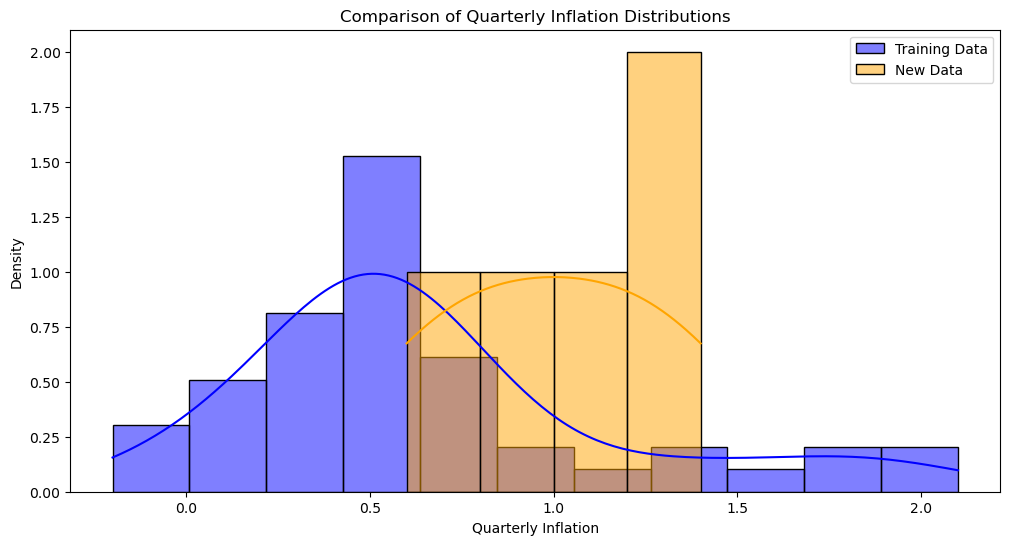

In [26]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 15 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 11: Prediction Studies with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Compare distributions of a feature
plt.figure(figsize=(12, 6))
sns.histplot(final_combined_data_cleaned['Quarterly inflation'], color='blue', label='Training Data', kde=True, stat='density')
sns.histplot(NewData['Quarterly inflation'], color='orange', label='New Data', kde=True, stat='density')
plt.legend()
plt.title('Comparison of Quarterly Inflation Distributions')
plt.xlabel('Quarterly Inflation')
plt.ylabel('Density')
plt.show()


In [27]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 15 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

#Viewing the new data ready to use to test the tkinter program:
selected_columns = NewData[['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']]

# Print the selected columns
selected_columns.head()


,Quarterly inflation,Premium unleaded petrol (95 RON) (cpl),Price_diff_Premium
Date,,,
01/03/2023,1.4,199,0.0
01/06/2023,0.8,199,0.0
01/09/2023,1.2,213,14.0
01/12/2023,0.6,212,-1.0
01/03/2024,1.0,211,-1.0


***

### Tkinter Program:

In [28]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 3 10/2024
#Programming: Python, Data Science
#*******************************
# G. Chetty, "Module 3: Decision Structures and Boolean Logic," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
# G. Chetty, "Module 7: Objects and Classes," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].
#G. Chetty, "Module 5: Modularising Code with Functions," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].


class FuelPricePredictionApp:
    def __init__(self, master):
        self.master = master
        self.master.title('Premium Fuel Price Prediction')

        # Load datasets
        self.load_data()

        # Prepare data for prediction
        self.prepare_data()

        self.sliders = []
        self.create_widgets()

        # Train the model on all data
        self.train_model()

    def load_data(self):
        # Load the datasets
        fuelPriceData = pd.read_csv(r"C:\Users\tsche\OneDrive - University of Canberra - STUDENT\My Life Control Centre\Education\Software Engineering UC\Sem 2 2024\Software Technology 1\Assignment 3\Report\Coding\Fuel prices quarterly.csv")
        rbaCpiData = pd.read_csv(r"C:\Users\tsche\OneDrive - University of Canberra - STUDENT\My Life Control Centre\Education\Software Engineering UC\Sem 2 2024\Software Technology 1\Assignment 3\Report\Coding\RBA CPI data.csv")
        
        # Merge datasets based on a common column, e.g., 'Date'
        self.data = pd.merge(fuelPriceData, rbaCpiData, on='Date', how='inner')

        # Print column names for debugging
        print("Columns in the merged data:", self.data.columns.tolist())

    def prepare_data(self):
        # Check if 'Quarterly inflation' exists, adjust according to the merged DataFrame
        if 'Quarterly inflation' not in self.data.columns:
            print("Warning: 'Quarterly inflation' is not present in the data.")
        
        # Create new columns for price differences, etc.
        self.data['Price_diff_Premium'] = self.data['Premium unleaded petrol (95 RON) (cpl)'].diff()
        self.data['Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'] = self.data['Premium unleaded petrol (95 RON) (cpl)'].shift(-1)
        
        # Drop NaN values
        self.data = self.data.dropna()

        # Define predictors and target variable
        self.Predictors = ['Quarterly inflation', 'Premium unleaded petrol (95 RON) (cpl)', 'Price_diff_Premium']
        self.TargetVariable = 'Premium unleaded petrol (95 RON) (cpl)_Next_Quarter'

    def create_widgets(self):
        for i, column in enumerate(self.Predictors):
            label = tk.Label(self.master, text=column + ': ')
            label.grid(row=i, column=0)
            current_val_label = tk.Label(self.master, text='0.0')
            current_val_label.grid(row=i, column=2)
            slider = ttk.Scale(self.master, from_=self.data[column].min(), to=self.data[column].max(), orient="horizontal",
                               command=lambda val, label=current_val_label: label.config(text=f'{float(val):.2f}'))
            slider.grid(row=i, column=1)
            self.sliders.append((slider, current_val_label))

        predict_button = tk.Button(self.master, text='Predict Price', command=self.predict_price)
        predict_button.grid(row=len(self.Predictors), columnspan=3)

    def train_model(self):
        # Prepare features and target
        X = self.data[self.Predictors]
        y = self.data[self.TargetVariable]

        # Train the Linear Regression model
        self.model = LinearRegression()
        self.model.fit(X, y)

        # Optionally, evaluate the model performance
        predictions = self.model.predict(X)
        print("R² Score on training data:", r2_score(y, predictions))

    def predict_price(self):
        # Gather inputs from sliders
        inputs = [float(slider.get()) for slider, _ in self.sliders]

        # Create a DataFrame with the same feature names
        input_df = pd.DataFrame([inputs], columns=self.Predictors)

        # Predict the price using the trained model
        price = self.model.predict(input_df)

        # Display the predicted price
        messagebox.showinfo('Predicted Price', f'The predicted premium fuel price is ${price[0]:.2f}')

if __name__ == '__main__':
    root = tk.Tk()
    app = FuelPricePredictionApp(root)
    root.mainloop()


Columns in the merged data: ['Date', 'Premium unleaded petrol (95 RON) (cpl)', 'Regular unleaded petrol (91 RON) (cpl)', 'Quarterly inflation']
R² Score on training data: 0.8702128856027374


# Visualising the results of the Linear Regression model:

In [ ]:
#*******************************
#Author:
#u3167849 Assessment 3_Step 3 10/2024
#Programming: Python, Data Science
#*******************************
#G. Chetty, "Module 10: Visualisation with Python," University of Canberra, 2024. [Online]. Available: University PDF slides. [Accessed: Oct. 2024].

# Create a figure and axis object 
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test.index, y_test, color='blue', label='Actual Prices', marker='o')

# Plot predicted values
plt.plot(y_test.index, predictions, color='red', label='Predicted Prices', marker='x')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Premium unleaded petrol (95 RON) (cpl)')
plt.title('Actual vs Predicted Premium Prices (Test Data)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Define model names
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'KNN', 'SVM']

# Define accuracy scores (based on earlier results)
mean_accuracies = [94.95, 83.66, 93.57, 92.83, 93.4, 91.31, 90.04]
median_accuracies = [92.85, 79.48, 79.56, 82.66, 78.79, 79.56, 79.04]

# Plotting Mean Accuracy
plt.figure(figsize=(10, 6))
plt.barh(models, mean_accuracies, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Model Mean Accuracy Comparison', fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()